In [1]:
import kastredux
import glob
import os
import numpy
import numpy as np
import matplotlib.pyplot as plt
import copy
import astropy.io.fits as fits

from scipy.interpolate import interp1d
from scipy.integrate import trapz

from splat.utilities import typeToNum

In [2]:
sp1_path = '/home/ryan/projects/Kast_Reduct/20191208/reduction/kastRED_J0906-0848B_20191208.fits'
sp1 = kastredux.readSpectrum(sp1_path)
sp1.name = fits.getheader(sp1_path)['OBJECT']

sp2_path = '/home/ryan/projects/Kast_Reduct/20191208/reduction/kastRED_J0906-0848A_20191208.fits'
sp2 = kastredux.readSpectrum(sp2_path)
sp2.name = fits.getheader(sp2_path)['OBJECT']

stand1_path = '/home/ryan/code/kastredux/resources/spectral_standards/T50_2MASS0559-1404-burgasser2003.txt'
stand1 = kastredux.readSpectrum(stand1_path)
stand1.name = os.path.basename(os.path.splitext(stand1_path)[0])

stand2_path = '/home/ryan/code/kastredux/resources/spectral_standards/M70_SDSS-bochanski2007.txt'
stand2 = kastredux.readSpectrum(stand2_path)
stand2.name = os.path.basename(os.path.splitext(stand2_path)[0])

stand3_path = '/home/ryan/code/kastredux/resources/spectral_standards/M00_SDSS-bochanski2007.txt'
stand3 = kastredux.readSpectrum(stand3_path)
stand3.name = os.path.basename(os.path.splitext(stand3_path)[0])

In [3]:
file_path = '/home/ryan/projects/Kast_Reduct/final/'

suffix = '*.fits'

filepaths = glob.glob(file_path + suffix)

SPECTRA = []
for filepath in filepaths:
    
    spectrum = kastredux.readSpectrum(filepath)
    spectrum.name = fits.getheader(filepath)['OBJECT']
    
    SPECTRA.append(spectrum)
    
    

In [4]:
def spt_from_name(name):
    
    spt = name.split('_')[0]
    
    return spt

def classify_by_standard(spec, ref='lepine', plot=False):
    
    lepine_str = 'lepine'
    kirkpatrick_str = 'kirkpatrick'
    burgasser_str = 'burgasser'
    all_str = 'all'
    
    LEPINE_STANDARDS = []
    KIRKPATRICK_STANDARDS = []
    BURGASSER_STANDARDS = []
    
    STANDARD_PATHS = glob.glob(kastredux.SPTSTDFOLDER + '*.txt')

    
    for path in STANDARD_PATHS:
        name = os.path.basename(os.path.splitext(path)[0])
        stand_spec = kastredux.readSpectrum(path)
        stand_spec.name = name
        
        if (lepine_str in name):
            LEPINE_STANDARDS.append(stand_spec)
        elif (kirkpatrick_str in name):
            KIRKPATRICK_STANDARDS.append(stand_spec)
        elif (burgasser_str in name):
            BURGASSER_STANDARDS.append(stand_spec)

    
    minimal = 1e90
    minimal_scale = None
    minimal_standard = None
    minimal_standard_name = None
    
    COMPARISON = []
    
    if (ref in lepine_str):
        COMPARISON = LEPINE_STANDARDS
    elif (ref in kirkpatrick_str):
        COMPARISON = KIRKPATRICK_STANDARDS
    elif (ref in burgasser_str):
        COMPARISON = BURGASSER_STANDARDS
    elif (ref in all_str):
        COMPARISON = LEPINE_STANDARDS + KIRKPATRICK_STANDARDS + BURGASSER_STANDARDS
        
    for stand in COMPARISON:
        
        chi2, scalefactor = kastredux.compareSpectra_simple(spec, stand)

        
        if chi2 < minimal:
            minimal = chi2
            minimal_scale = scalefactor
            minimal_standard = stand
            minimal_standard_name = stand.name
            
    if plot:
        placeholder = kastredux.compareSpectra_simple(spec, minimal_standard, plot=True)
     
    spt = spt_from_name(minimal_standard_name)

    return spt, minimal_standard_name, minimal, minimal_scale

def classify_by_template(spec, ref='SDSS', plot=False):
    
    sdss_str = 'SDSS'
    all_str = 'all'
    
    SDSS_STANDARDS = []
    
    STANDARD_PATHS = glob.glob(kastredux.SPTSTDFOLDER + '*.txt')
    
    for path in STANDARD_PATHS:
        name = os.path.basename(os.path.splitext(path)[0])
        stand_spec = kastredux.readSpectrum(path)
        stand_spec.name = name
        
        if sdss_str in name:
            SDSS_STANDARDS.append(stand_spec)
    
    minimal = 1e70
    minimal_scale = None
    minimal_standard = None
    minimal_standard_name = None
    
    COMPARISON = []
    
    if ref in sdss_str:
        COMPARISON = SDSS_STANDARDS
    elif ref in all_str:
        COMPARISON = SDSS_STANDARDS
        
    
    for stand in COMPARISON:
        
        chi2, scalefactor = kastredux.compareSpectra_simple(spec, stand)

        
        if chi2 < minimal:
            minimal = chi2
            minimal_scale = scalefactor
            minimal_standard = stand
            minimal_standard_name = stand.name
            
    if plot:
        placeholder = kastredux.compareSpectra_simple(spec, minimal_standard, plot=True)
    
    spt = spt_from_name(minimal_standard_name)
    

    return spt, minimal_standard_name, minimal, minimal_scale

In [6]:
STAND_PATHS = glob.glob('/home/ryan/code/kastredux/resources/spectral_standards/' + '*.txt')

STANDARDS = []

for path in STAND_PATHS:
    name = os.path.basename(os.path.splitext(path)[0])
    stand_spec = kastredux.readSpectrum(path)
    stand_spec.name = name
    
    STANDARDS.append(stand_spec)
    

In [7]:
STAND_PATHS = glob.glob('/home/ryan/code/kastredux/resources/spectral_standards/' + '*.txt')

LEPINE_STANDARDS = []

lepine_str = 'lepine'

for path in STAND_PATHS:
    
    if lepine_str in path:
        name = os.path.basename(os.path.splitext(path)[0])
        stand_spec = kastredux.readSpectrum(path)
        stand_spec.name = name
    
        LEPINE_STANDARDS.append(stand_spec)

In [8]:
def measure_index(waves, fluxes, continuum_ranges, feature_ranges, method='ratio', sample='integrate', plot=False, name=None):
    
    #number of samples in interpolation
    no_samples = 1000
    
    #creating flux interpolation
    fluxinterp = interp1d(waves, fluxes, bounds_error=False, fill_value=0.)

    continuum_waves = []
    continuum_fluxes = []
    
    #getting the continuum flux
    for continuum_range in continuum_ranges:
            
        min_wavelength = continuum_range[0]
        max_wavelength = continuum_range[1]
            
        no_divisions = (max_wavelength - min_wavelength) * no_samples
            
        w = numpy.linspace(min_wavelength, max_wavelength, no_divisions)
        
        continuum_waves.append(w)
        
        f = fluxinterp(w)
            
        continuum_flux = f[ (w >= min_wavelength) & (w <= max_wavelength) ]
            
        continuum_fluxes.append(continuum_flux)
    
    feature_waves = []
    feature_fluxes = []
    
    #getting the feature flux
    for feature_range in feature_ranges:
            
        min_wavelength = feature_range[0]
        max_wavelength = feature_range[1]
            
        no_divisions = (max_wavelength - min_wavelength) * no_samples
            
        w = numpy.linspace(min_wavelength, max_wavelength, no_divisions)
        
        feature_waves.append(w)
        
        f = fluxinterp(w)
            
        feature_flux = f[ (w >= min_wavelength) & (w <= max_wavelength) ]
            
        feature_fluxes.append(feature_flux)

    #plot the regions
    if plot:
        
        for waves, fluxes in zip(continuum_waves, continuum_fluxes):
            plt.figure(figsize=[12,7])
            plt.plot(waves, fluxes)
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/(Angstrom cm2 s))')
            plt.title('{} Continuum'.format(name))
            plt.show()
            
        for waves, fluxes in zip(feature_waves, feature_fluxes):
            plt.figure(figsize=[12,7])
            plt.plot(waves, fluxes)
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/(Angstrom cm2 s))')
            plt.title('{} Feature'.format(name))
            plt.show()
    
    #calculate samples
    continuum_values = []
    feature_values = []
    
    #only average and integrate are implemented
    if 'average' in sample:
        
        for waves, fluxes in zip(continuum_waves, continuum_fluxes):
            
            continuum_value = np.mean(fluxes)
            continuum_values.append(continuum_value)
            
        for waves, fluxes in zip(feature_waves, feature_fluxes):
            
            feature_value = np.mean(fluxes)
            feature_values.append(feature_value)
            
    elif 'integrate' in sample:
        
        for waves, fluxes in zip(continuum_waves, continuum_fluxes):
            
            continuum_value = trapz(fluxes, waves)
            continuum_values.append(continuum_value)
            
        for waves, fluxes in zip(feature_waves, feature_fluxes):
            
            feature_value = trapz(fluxes, waves)
            feature_values.append(feature_value)
    
    elif 'sum' in sample:
        
        for waves, fluxes in zip(continuum_waves, continuum_fluxes):
            
            continuum_value = np.sum(fluxes)
            continuum_values.append(continuum_value)
            
        for waves, fluxes in zip(feature_waves, feature_fluxes):
            
            feature_value = np.sum(fluxes)
            feature_values.append(feature_value)
        
            
    
    #calculate the index
    if 'ratio' in method:
        
        index = feature_values[0] / continuum_values[0]
        
        return index
        
    elif 'sumnum' in method:
        
        numerator = np.sum(feature_values)
        index = numerator / continuum_values[0]
        
        return index
        
    elif 'sumdenom' in method:
        
        denominator = np.sum(continuum_values)
        index = feature_values[0] / denominator
        
        return index
    
    elif 'avnum' in method:
        
        numerator = np.mean(feature_values)
        index = numerator / continuum_values[0]
        
        return index
    
    elif 'avdenom' in method:
        
        denominator = np.mean(continuum_values)
        index = feature_values[0] / denominator
        
        return index
    
    elif 'sumnum_twicedenom' in method:
        
        denominator = 2 * continuum_values[0]
        
        numerator = np.sum(feature_values)
        
        index = numerator / denominator
        
        return index
    
    else:
        return np.nan
            
            


def measure_index_set(spec, ref='lepine2007', index_info=None, plot=False):
    
    indices_keyword = 'indices'
    continuum_keyword = 'continuum'
    feature_keyword = 'feature'
    method_keyword = 'method'
    sample_keyword = 'sample'
    
    #leipine (2007)
    if 'lepine2007' in ref:
        index_info = {'indices': {\
        'CaH3': {'feature': [[6960,6990]],\
                 'continuum': [[7042,7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'CaH2': {'feature': [[6814, 6846]],\
                 'continuum': [[7042, 7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'TiO5': {'feature': [[7126,7135]],\
                 'continuum': [[7042,7046]],\
                 'method': 'ratio',\
                 'sample': 'average'}
        }}
    
    #lepine (2003)
    elif 'lepine2003' in ref:
        index_info = {'indices': {\
        'CaH1': {'feature': [[6380,6390]],\
                 'continuum': [[6410,6420], [6345, 6355]],\
                 'method': 'avdenom',\
                 'sample': 'average'},\
        'CaH2': {'feature': [[6814, 6846]],\
                 'continuum': [[7042, 7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'CaH3': {'feature': [[6960,6990]],\
                 'continuum': [[7042,7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'TiO5': {'feature': [[7126,7135]],\
                 'continuum': [[7042,7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'VO1': {'feature': [[7430, 7470]],\
                 'continuum': [[7550,7570]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'TiO6': {'feature': [[7550,7570]],\
                 'continuum': [[7745,7765]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'VO2': {'feature': [[7920, 7960]],\
                 'continuum': [[8440, 8470]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'TiO7': {'feature': [[8440, 8470]],\
                 'continuum': [[8400, 8420]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'Color-M': {'feature': [[8105, 8155]],\
                 'continuum': [[6510, 6560]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        }}
    
    #gizis (1997)
    elif 'gizis' in ref:
        index_info = {'indices': {\
        'TiO5': {'feature': [[7126, 7135]],\
                 'continuum': [[7042, 7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'CaH1': {'feature': [[6380, 6390]],\
                 'continuum': [[6345, 6355], [6410, 6420]],\
                 'method': 'avdenom',\
                 'sample': 'average'},\
        'CaH2': {'feature': [[6814, 6846]],\
                 'continuum': [[7042, 7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'CaH3': {'feature': [[6960, 6990]],\
                 'continuum': [[7042, 7046]],\
                 'method': 'ratio',\
                 'sample': 'average'}
        }}
     
    #reid (1995)
    elif 'reid' in ref:
        index_info = {'indices': {\
        'TiO1': {'feature': [[6718, 6723]],\
                 'continuum': [[6703, 6708]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'TiO2': {'feature': [[7058, 7061]],\
                 'continuum': [[7043, 7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'TiO3': {'feature': [[7092, 7097]],\
                 'continuum': [[7079, 7084]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'TiO4': {'feature': [[7130, 7135]],\
                 'continuum': [[7115, 7120]],\
                 'method': 'ratio',
                 'sample': 'average'},\
        'TiO5': {'feature': [[7126, 7135]],\
                 'continuum': [[7042, 7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'CaH1': {'feature': [[6380, 6390]],\
                 'continuum': [[6345, 6355], [6410, 6420]],\
                 'method': 'avdenom',
                 'sample': 'average'},\
        'CaH2': {'feature': [[6814, 6846]],\
                 'continuum': [[7042, 7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'CaH3': {'feature': [[6960, 6990]],\
                 'continuum': [[7042, 7046]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        'CaOH': {'feature': [[6230, 6240]],\
                 'continuum': [[6345, 6354]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        
        }}
        
    #kirkpatrick (1999)
    elif 'kirkpatrick' in ref:
        index_info = {'indices': {\
        'Rb-a': {'feature': [[7775.2, 7785.2], [7815.2, 7825.2]],\
                 'continuum': [[7795.2, 7805.2]],\
                 'method': 'avnum',\
                 'sample': 'integrate'},\
        'Rb-b': {'feature': [[7922.6, 7932.6], [7962.6, 7972.6]],\
                 'continuum': [[7942.6, 7952.6]],\
                 'method': 'avnum',\
                 'sample': 'integrate'},\
        'Na-a': {'feature': [[8153.3, 8163.3]],\
                 'continuum': [[8178.3, 8188.3]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'Na-b': {'feature': [[8153.3, 8183.3]],\
                 'continuum': [[8189.8, 8199.8]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'Cs-a': {'feature': [[8496.1, 8506.1], [8536.1, 8546.1]],\
                 'continuum': [[8516.1, 8526.1]],\
                 'method': 'avnum',\
                 'sample': 'integrate'},\
        'Cs-b': {'feature': [[8918.5, 8928.5], [8958.3, 8968.3]],\
                 'continuum': [[8938.5, 8948.3]],\
                 'method': 'avnum',\
                 'sample': 'integrate'},\
        'TiO-a': {'feature': [[7033.0, 7048.0]],\
                 'continuum': [[7958.0, 7973.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'TiO-b': {'feature': [[8400.0, 8415.0]],\
                 'continuum': [[8435.0, 8470.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'VO-a': {'feature': [[7350.0, 7370.0], [7550.0, 7570.0]],\
                 'continuum': [[7430.0, 7470.0]],\
                 'method': 'sumnum',\
                 'sample': 'integrate'},\
        'VO-b': {'feature': [[7860.0, 7880.0], [8080.0, 8100.0]],\
                 'continuum': [[7960.0, 8000.0]],\
                 'method': 'sumnum',\
                 'sample': 'integrate'},\
        'CrH-a': {'feature': [[8580.0, 8600.0]],\
                 'continuum': [[8621.0, 8641.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'CrH-b': {'feature': [[9940.0, 9960.0]],\
                 'continuum': [[9970.0, 9990.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'FeH-a': {'feature': [[8660.0, 8680.0]],\
                 'continuum': [[8700.0, 8720.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'FeH-b': {'feature': [[9863.0, 9883.0]],\
                 'continuum': [[9908.0, 9928.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'Color-a': {'feature': [[9800.0, 9850.0]],\
                 'continuum': [[7300.0, 7350.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'Color-b': {'feature': [[9800.0, 9850.0]],\
                 'continuum': [[7000.0, 7050.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'Color-c': {'feature': [[9800.0, 9850.0]],\
                 'continuum': [[8100.0, 8150.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'Color-d': {'feature': [[9675.0, 9875.0]],\
                 'continuum': [[7350.0, 7550.0]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        
        }}
        
    #burgasser (2003)
    elif 'burgasser' in ref:
        index_info = {'indices': {\
        'CsI(A)': {'feature': [[8496.1, 8506.1], [8536.1, 8546.1]],\
                 'continuum': [[8516.1, 8626.1]],\
                 'method': 'sumnum_twicedenom',\
                 'sample': 'average'},\
        'CsI(B)': {'feature': [[8918.5, 8928.5], [8958.3, 8968.3]],\
                 'continuum': [[8938.5, 8948.3]],\
                 'method': 'sumnum_twicedenom',\
                 'sample': 'average'},\
        'H2O': {'feature': [[9220, 9240]],\
                 'continuum': [[9280, 9300]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'CrH(A)': {'feature': [[8560, 8600]],\
                 'continuum': [[8610, 8650]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'CrH(B)': {'feature': [[9855, 9885]],\
                 'continuum': [[9970, 10000]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'FeH(A)': {'feature': [[8560, 8600]],\
                 'continuum': [[8685, 8725]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'FeH(B)': {'feature': [[9855, 9885]],\
                 'continuum': [[9905, 9935]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'Color-e': {'feature': [[9140, 9240]],\
                 'continuum': [[8400, 8500]],\
                 'method': 'ratio',\
                 'sample': 'average'},\
        }}
        
    #martin (1999)
    elif 'martin' in ref:
                index_info = {'indices': {\
        'PC3': {'feature': [[8230, 8270]],\
                 'continuum': [[7540, 7580]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'PC6': {'feature': [[9090, 9130]],\
                 'continuum': [[6500, 6540]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'CrH1': {'feature': [[8560, 8600]],\
                 'continuum': [[8610, 8650]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'CrH2': {'feature': [[9840, 9880]],\
                 'continuum': [[9970, 10010]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'FeH1': {'feature': [[8560, 8600]],\
                 'continuum': [[8685, 8725]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'FeH2': {'feature': [[9840, 9880]],\
                 'continuum': [[9900, 9940]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'H2O1': {'feature': [[9190, 9230]],\
                 'continuum': [[9280, 9320]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'TiO1': {'feature': [[7000, 7040]],\
                 'continuum': [[7060, 7100]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'TiO2': {'feature': [[8380, 8420]],\
                 'continuum': [[8440, 8480]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'VO1': {'feature': [[7540, 7580]],\
                 'continuum': [[7420, 7460]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        'VO2': {'feature': [[7990, 8030]],\
                 'continuum': [[7900, 7940]],\
                 'method': 'ratio',\
                 'sample': 'integrate'},\
        }}
        
    names = list(index_info[indices_keyword])
    
    result = {}
    for n in names:
        
        waves = spec.wave.value
        flx = spec.flux.value
        unc = spec.unc.value
        
        #measuring the value here
        
        index = measure_index(waves, flx,\
         index_info[indices_keyword][n][continuum_keyword],\
         index_info[indices_keyword][n][feature_keyword],\
         index_info[indices_keyword][n][method_keyword],\
         index_info[indices_keyword][n][sample_keyword], plot, name=n)
        
        #doing MC here for error
        no_trials = 1000
        
        index_samples = []
        
        
        for i in range(no_trials):
            flxdist = np.random.normal(flx, unc)
            
            index_sample = measure_index(waves, flxdist,\
             index_info[indices_keyword][n][continuum_keyword],\
             index_info[indices_keyword][n][feature_keyword],\
             index_info[indices_keyword][n][method_keyword],\
             index_info[indices_keyword][n][sample_keyword])
            
            index_samples.append(index_sample)
            

        err = np.std(index_samples)
        
        result[n] = (index, err)
        
    return result

def measure_solar_TiO5(spec):
    
    indices = measure_index_set(spec, ref='lepine2007')
    
    #unpacking values
    
    CaH3 = indices['CaH3'][0]
    CaH3_err = indices['CaH3'][1]
    
    CaH2 = indices['CaH2'][0]
    CaH2_err = indices['CaH2'][1]
    
    #getting the measurement here
    solar_TiO5_measurement = solar_TiO5(CaH2, CaH3)
    
    #doing MC here
    no_trials = 1000
    
    CaH3_samps = np.random.normal(CaH3, CaH3_err, no_trials)
    
    CaH2_samps = np.random.normal(CaH2, CaH2_err, no_trials)
    
    solar_TiO5_samps = solar_TiO5(CaH2_samps, CaH3_samps)
    

    
    solar_TiO5_err = np.std(solar_TiO5_samps)
    
    return solar_TiO5_measurement, solar_TiO5_err

def measure_spt(spec, ref='lepine2007'):
    
    if 'lepine2007' in ref:
        indices = measure_index_set(spec, ref='lepine2007')

        #unpacking values

        CaH3 = indices['CaH3'][0]
        CaH3_err = indices['CaH3'][1]

        CaH2 = indices['CaH2'][0]
        CaH2_err = indices['CaH2'][1]

        #getting the value here
        lepine_spt_measurement = lepine_spt(CaH2, CaH3)

        #doing MC here
        no_trials = 1000

        CaH3_samps = np.random.normal(CaH3, CaH3_err, no_trials)

        CaH2_samps = np.random.normal(CaH2, CaH2_err, no_trials)

        lepine_spt_samps = lepine_spt(CaH2_samps, CaH3_samps)


        lepine_spt_err = np.std(lepine_spt_samps)
        
        return lepine_spt_measurement, lepine_spt_err
    
    elif 'gizis' in ref:
        indices = measure_index_set(spec, ref='gizis')

        TiO5_index = indices['TiO5'][0]
        TiO5_err = indices['TiO5'][1]

        CaH2_index = indices['CaH2'][0]
        CaH2_err = indices['CaH2'][1]

        CaH3_index = indices['CaH3'][0]
        CaH3_err = indices['CaH3'][1]

        TiO5_spt, CaH2_spt, CaH3_spt = gizis_spt(TiO5_index, CaH2_index, CaH3_index)

        #doing MC

        no_trials = 1000

        TiO5_samps = np.random.normal(TiO5_index, TiO5_err, no_trials)
        CaH2_samps = np.random.normal(CaH2_index, CaH2_err, no_trials)
        CaH3_samps = np.random.normal(CaH3_index, CaH3_err, no_trials)

        TiO5_spt_samps, CaH2_spt_samps, CaH3_spt_samps = gizis_spt(TiO5_samps, CaH2_samps, CaH3_samps)

        TiO5_spt_err = np.std(TiO5_spt_samps)
        CaH2_spt_err = np.std(CaH2_spt_samps)
        CaH3_spt_err = np.std(CaH3_spt_samps)

        return (TiO5_spt, TiO5_spt_err), (CaH2_spt, CaH2_spt_err), (CaH3_spt, CaH3_spt_err)



def measure_lepine_zeta(spec):
    
    indices = measure_index_set(spec, ref='lepine2007')
    
    #unpacking values
    
    
    TiO5 = indices['TiO5'][0]
    TiO5_err = indices['TiO5'][1]
    
    solar_TiO5, solar_TiO5_err = measure_solar_TiO5(spec)
    
    #getting the measurement
    lepine_zeta_measurement = lepine_zeta(TiO5, solar_TiO5)
    
    #doing MC for error here
    no_trials = 1000
    
    TiO5_samps = np.random.normal(TiO5, TiO5_err, no_trials)
    
    solar_TiO5_samps = np.random.normal(solar_TiO5, solar_TiO5_err, no_trials)
    
    lepine_zeta_samps = lepine_zeta(TiO5_samps, solar_TiO5_samps)
    
    
    lepine_zeta_err = np.std(lepine_zeta_samps)
    
    return lepine_zeta_measurement, lepine_zeta_err
    

def solar_TiO5(CaH2, CaH3):
    
    CaH = CaH2 + CaH3
    
    solar_TiO5 = -0.164 * CaH**3 + 0.670 * CaH**2 - 0.118 * CaH - 0.050
    
    return solar_TiO5

def lepine_zeta(TiO5, solar_TiO5):
    
    zeta = (1 - TiO5)/(1 - solar_TiO5)
    
    return zeta

def lepine_spt(CaH2, CaH3):
    CaH = CaH2 + CaH3
    
    spt = 1.4 * CaH**2 - 10. * CaH + 12.4
    
    return spt
    
def determine_metallicity_class(zeta):
    
    
    metallicity_class = ''
    
    
    if zeta > 0.825:
        
        metallicity_class = 'Dwarf'
        
    elif ((zeta > 0.500) and (zeta < 0.825)):
        
        metallicity_class = 'sd'
        
    elif ((zeta > 0.200) and (zeta < 0.500)):
        
        metallicity_class = 'esd'
        
    elif zeta < 0.200:
        
        metallicity_class = 'usd'
        
    else:
        metallicity_class = 'Unknown'
          
    return metallicity_class

def gizis_spt(TiO5, CaH2, CaH3):
    
    TiO5_spt = -9.64 * TiO5 + 7.76
    CaH2_spt = 7.91 * CaH2**2 - 20.63 * CaH2 + 10.71
    CaH3_spt = -18. * CaH3 + 15.8
    
    return TiO5_spt, CaH2_spt, CaH3_spt

    
        

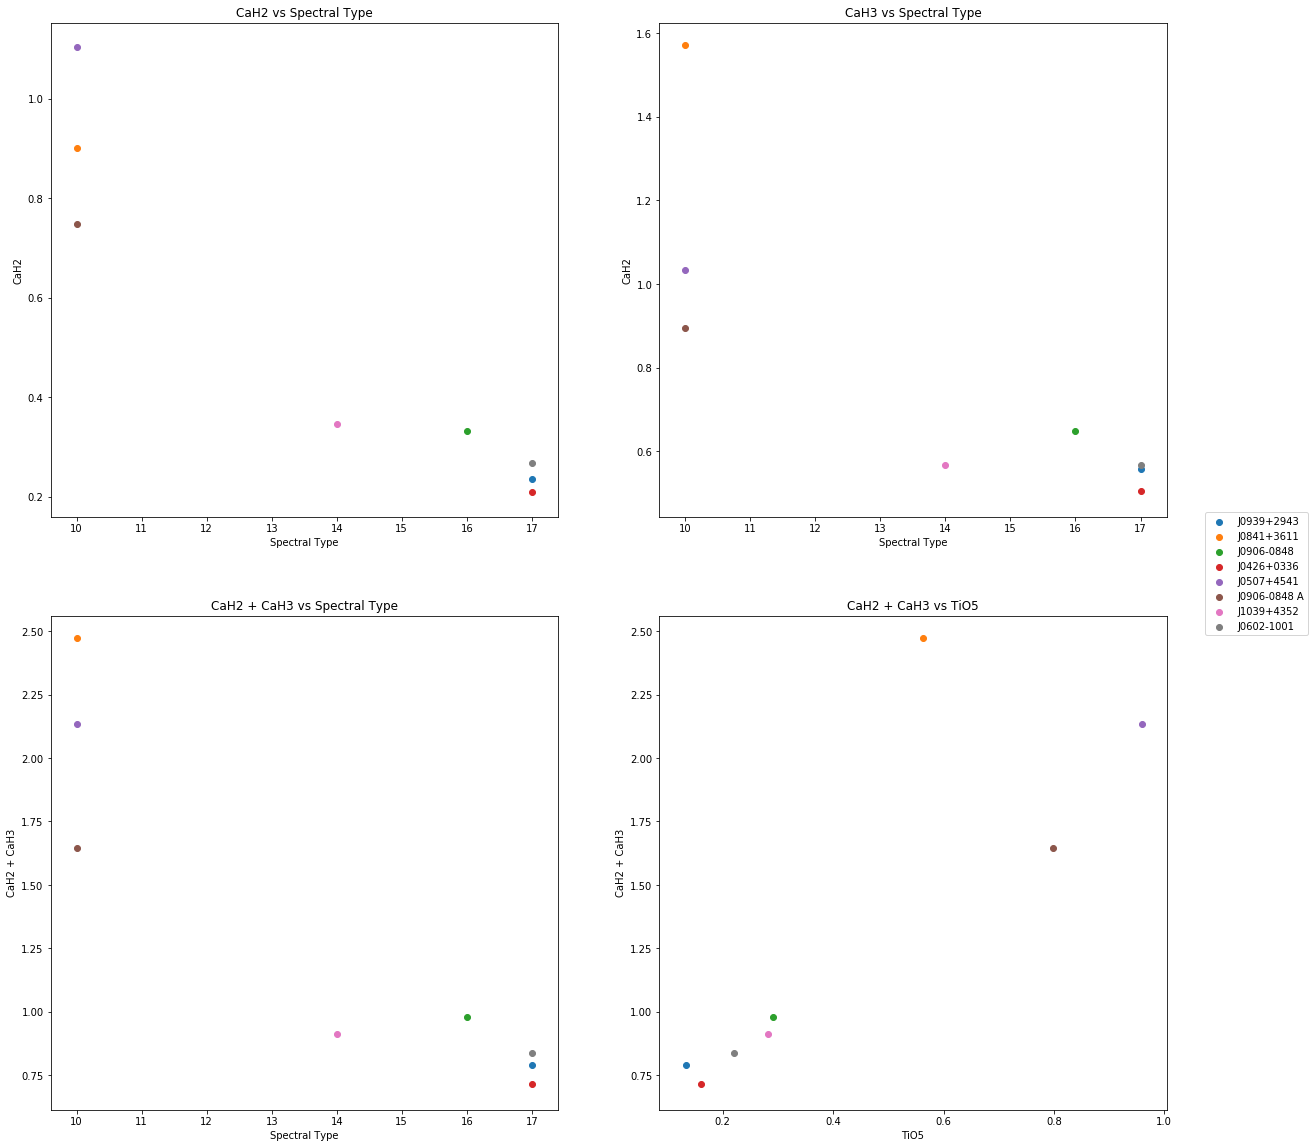

In [17]:
fig, axs = plt.subplots(2, 2, figsize=[20,20])

for spec in SPECTRA:
    spt, minimal_name, minimal_chi2, minimal_scale = classify_by_template(spec)
    
    spt_n = typeToNum(spt)
    
    indices = measure_index_set(spec, ref='lepine2007')
    
    CaH2 = indices['CaH2'][0]
    CaH3 = indices['CaH3'][0]
    
    TiO5 = indices['TiO5'][0]
    
    CaH = CaH2 + CaH3
    
    axs[0,0].scatter(spt_n, CaH2)
    axs[0,1].scatter(spt_n, CaH3)
    axs[1,0].scatter(spt_n, CaH, label=spec.name)
    
    axs[1,1].scatter(TiO5, CaH)
    
axs[0,0].set_title('CaH2 vs Spectral Type')
axs[0,0].set_xlabel('Spectral Type')
axs[0,0].set_ylabel('CaH2')
axs[0,1].set_title('CaH3 vs Spectral Type')
axs[0,1].set_xlabel('Spectral Type')
axs[0,1].set_ylabel('CaH2')
axs[1,0].set_title('CaH2 + CaH3 vs Spectral Type')
axs[1,0].set_xlabel('Spectral Type')
axs[1,0].set_ylabel('CaH2 + CaH3')
axs[1,1].set_title('CaH2 + CaH3 vs TiO5')
axs[1,1].set_xlabel('TiO5')
axs[1,1].set_ylabel('CaH2 + CaH3')
    
fig.legend(loc=7)
    
fig.show()
    

<Figure size 432x288 with 0 Axes>

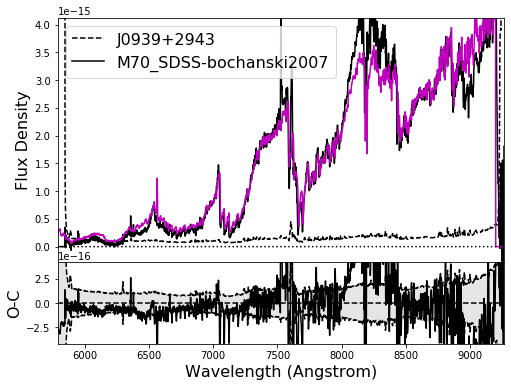

<Figure size 432x288 with 0 Axes>

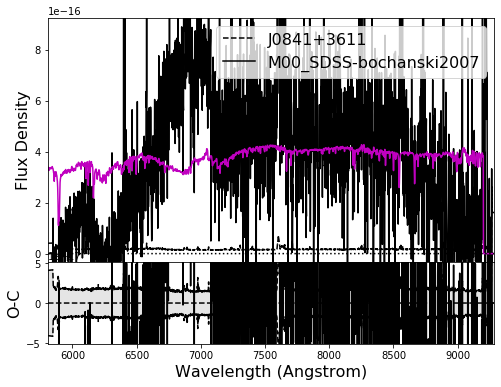

<Figure size 432x288 with 0 Axes>

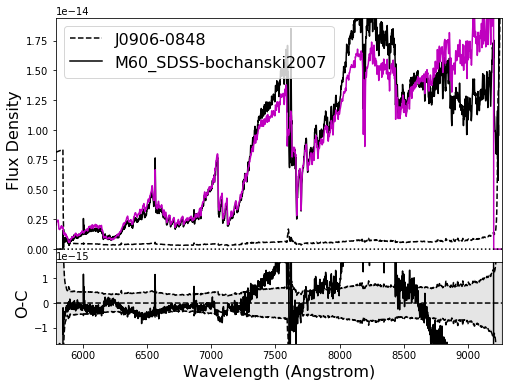

<Figure size 432x288 with 0 Axes>

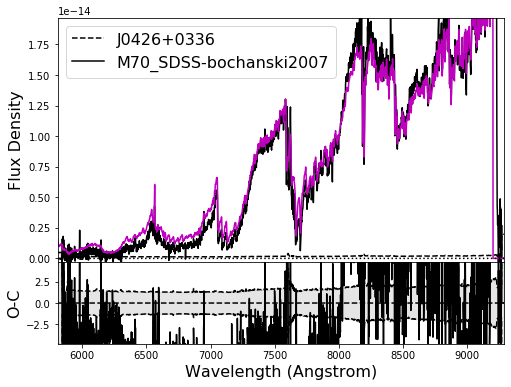

<Figure size 432x288 with 0 Axes>

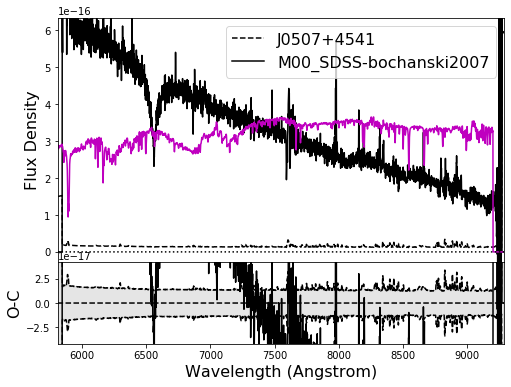

<Figure size 432x288 with 0 Axes>

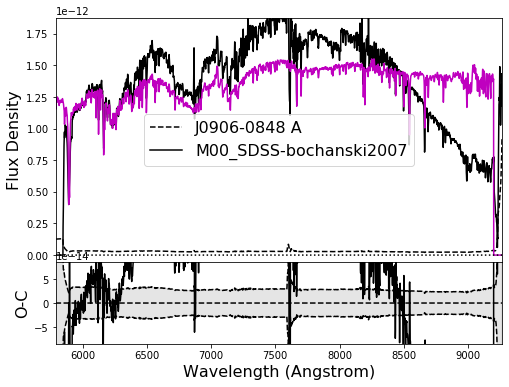

<Figure size 432x288 with 0 Axes>

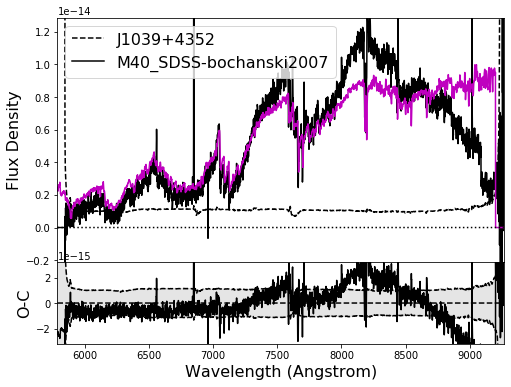

<Figure size 432x288 with 0 Axes>

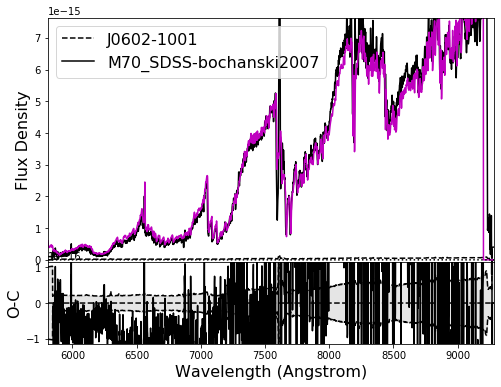

In [21]:
for spec in SPECTRA:
    info_tuple = classify_by_template(spec, plot=True)
    plt.show()

In [11]:
measure_index_set(sp1, ref='kirkpatrick')

/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in double_scalars


{'Rb-a': (1.093481368463627, 0.027493892098396953),
 'Rb-b': (1.0796073465813874, 0.023566296498360645),
 'Na-a': (1.337727723680996, 0.026788897881865715),
 'Na-b': (4.152118897392347, 0.0734213279839894),
 'Cs-a': (1.0922952188075317, 0.021545164750578893),
 'Cs-b': (1.02660903951163, 0.02751122807465887),
 'TiO-a': (0.5894915597076726, 0.013379106632732386),
 'TiO-b': (0.6024341942597687, 0.00824576070042344),
 'VO-a': (1.0286530462209693, 0.012065758623568446),
 'VO-b': (1.158692357539012, 0.014047767476923191),
 'CrH-a': (1.0211300810280917, 0.016387010891543364),
 'CrH-b': (nan, nan),
 'FeH-a': (1.0897050643742894, 0.018817437526203035),
 'FeH-b': (nan, nan),
 'Color-a': (0.0, 0.0),
 'Color-b': (0.0, 0.0),
 'Color-c': (0.0, 0.0),
 'Color-d': (0.0, 0.0)}

In [22]:
indices = measure_index_set(sp1, ref='gizis')

In [23]:
print(indices['CaH1'][0])
print(indices['CaH2'][0])
print(indices['CaH3'][0])
print(indices['TiO5'][0])

0.7941940672439514
0.33169326337558375
0.6481986008837284
0.2915542759909266


In [20]:
measure_spt(sp1, ref='gizis')

((4.949416779447468, 0.16893240078442365),
 (4.737429506424476, 0.22303055224126914),
 (4.13242518409289, 0.4550503829132531))

In [32]:
indices['Cs-a'][0] / indices['VO-b'][0]


0.9426964903155971

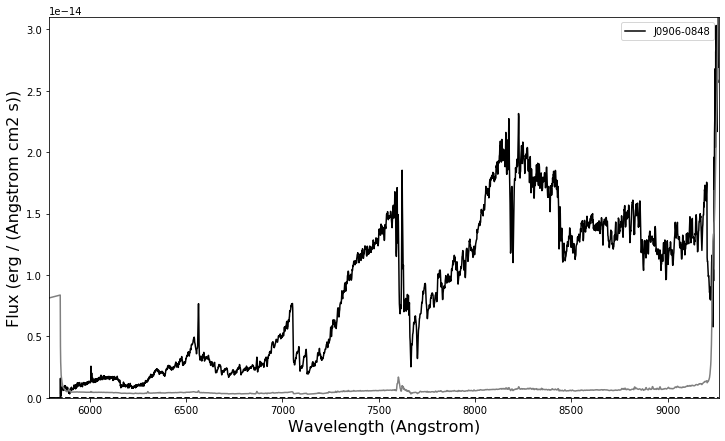

In [37]:
sp1.plot(figsize=[12,7])

In [154]:
def measure_EW_simple(spec, feature_center, feature_radius, continuum_radius, plot=False):
    waves = spec.wave.value
    fluxes = spec.flux.value
    
    no_samples = 1000
    
    left_bound = feature_center - feature_radius
    right_bound = feature_center + feature_radius
    
    no_divisions = (feature_center + continuum_radius - (feature_center - continuum_radius)) * no_samples
    
    finterp = interp1d(waves, fluxes, bounds_error=False, fill_value=0.)
    
    feature_waves = np.linspace(feature_center - feature_radius, feature_center + feature_radius, no_divisions)
    continuum_waves = np.linspace(feature_center - continuum_radius, feature_center + continuum_radius, no_divisions)
    
    continuum_fluxes = finterp(continuum_waves)
    feature_flux = finterp(feature_waves)
    
    waves_away_from_feature = continuum_waves[ (continuum_waves <= left_bound) | (continuum_waves >= right_bound) ]
    
    flux_away_from_feature = continuum_fluxes[ (continuum_waves <= left_bound) | (continuum_waves >= right_bound) ]
    
    continuum_fit = np.poly1d( np.polyfit(waves_away_from_feature, flux_away_from_feature, 1) )
    
    
    center_wave = feature_center
    
    continuum_level = continuum_fit(center_wave)
    
    width = trapz( (np.ones(len(feature_flux)) - feature_flux / continuum_level), feature_waves)
    
    if plot:
        
        from matplotlib import patches
        lower_left = feature_center - width/2
        
        fig, ax = plt.subplots(1, figsize=[12, 7])
        
        rect = patches.Rectangle( (lower_left, 0), width, continuum_level, fill=False, hatch='/')
        
        
        ax.add_patch(rect)
        
        ax.plot(continuum_waves, continuum_fluxes)
        
        ax.plot(continuum_waves, continuum_fit(continuum_waves))
        
        ax.axhline(continuum_level)
        
        fig.show()
        
    return width

/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


4.166448881014633

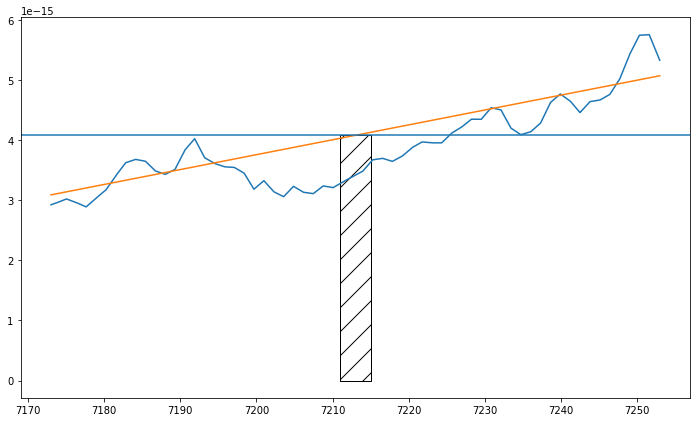

In [161]:
measure_EW_simple(sp1, 7213, 20, 40, plot=True)

In [ ]:
for stand in LEPINE_STANDARDS:
    
    indices = measure_index_set(stand, ref='lepine2007')
    
    print(indices)

In [62]:
#OLD
'''
measure_index_set(sp1, ref='lepine')
'''

{'CaH3': (0.6490527999040103, 0.025104920880684643),
 'CaH2': (0.3319778694090283, 0.01474269079440337),
 'TiO5': (0.2918329892314886, 0.018152477825190402)}

In [19]:
measure_solar_TiO5(sp1)

(0.3233943663135689, 0.021499820617438443)

In [63]:
#OLD
'''
measure_solar_TiO5(sp1)
'''

(0.3247650062922306, 0.02110637733620173)

In [20]:
measure_lepine_spt(sp1)

(3.9453446493051096, 0.2164505981498731)

In [68]:
#OLD
'''measure_lepine_spt(sp1)'''

(3.9329689140666795, 0.21271224357268168)

In [21]:
measure_lepine_zeta(sp1)

(1.047058565192792, 0.04210051889235641)

In [66]:
#OLD
'''measure_lepine_zeta(sp1)'''

(1.0481946923240055, 0.04290994735291789)

In [22]:
zeta = measure_lepine_zeta(sp1)[0]
determine_metallicity_class(zeta)

'Dwarf'

In [25]:
print(measure_lepine_indices(sp1))
print(measure_lepine_zeta(sp1))
print(measure_lepine_spt(sp1))

[0.6481988396642226, 0.33169267445447903, 0.29154963469410416]
1.0470650333057023
3.945347190031562


In [7]:
print(measure_lepine_indices(sp2))
print(measure_lepine_zeta(sp2))
print(measure_lepine_spt(sp2))

[0.8954600852555947, 0.7489002050531942, 0.7989483844199139]
1.2442262094235188
-0.2581138330057229


In [8]:
STATS = []
NAMES = []

for spec in STANDARDS:
    stat, scalefactor = kastredux.compareSpectra_simple(sp1, spec, novar2=False)
    
    #print('chi2: {}; name: {}'.format(stat, spec.name))
    
    STATS.append(stat)
    NAMES.append(spec.name)
    
print(np.amin(STATS))
print(NAMES[np.argmin(STATS)])

17841.46705228801
M60_SDSS-bochanski2007


In [9]:
STATS = []
NAMES = []

for spec in STANDARDS:
    stat, scalefactor = kastredux.compareSpectra_simple(sp2, spec, novar2=False)
    
    #print('chi2: {}; name: {}'.format(stat, spec.name))
    
    STATS.append(stat)
    NAMES.append(spec.name)
    
print(np.amin(STATS))
print(NAMES[np.argmin(STATS)])

301413.4185738305
M00_SDSS-bochanski2007


(301413.4185738305, 1.5536169095642894e-12)

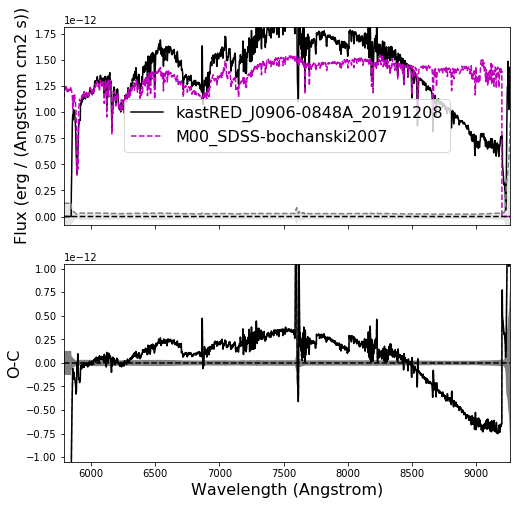

In [10]:
kastredux.compareSpectra_simple(sp2, stand3, plot=True)

In [23]:
for stand in LEPINE_STANDARDS:
    spt = measure_lepine_spt(stand)
    zeta = measure_lepine_zeta(stand)
    
    print('{}: \tspt: {}\tz: {}'.format(stand.name, spt, zeta))

sdM10_LSPMJ0938+2200-lepine2007: 	spt: 0.8900538738075046	z: 0.8135455813908783
usdM55_LSPMJ1202+1645-lepine2007: 	spt: 5.3345922413390685	z: 0.01828682660744999
sdM50_LSPMJ1448+6148-lepine2007: 	spt: 5.117203378093254	z: 0.6924521664562503
sdM20_LSPMJ1014+4354-lepine2007: 	spt: 1.8647819830774601	z: 0.6892053438412453
usdM20_LSPMJ0440+1538-lepine2007: 	spt: 1.8037094216942666	z: -0.04254823585449559
esdK70_LSPMJ0448+2206-lepine2007: 	spt: -0.9129413841861282	z: 0.6562963098591946
usdM75_LSPMJ0822+1700-lepine2007: 	spt: 7.6640156767016725	z: 0.11880308343058481
usdM00_LSPMJ0621+6558-lepine2007: 	spt: 0.10444394947498026	z: 0.10264688574863531
esdM30_LSPMJ1337+3501-lepine2007: 	spt: 2.771671654625786	z: 0.38812802173130234
esdM40_LSPMJ1340+1902-lepine2007: 	spt: 4.211210399708962	z: 0.2817846715013545
esdM50_LSPMJ0843+0600-lepine2007: 	spt: 5.01233613874156	z: 0.3120433294209408
usdK70_LSPMJ1815+2029-lepine2007: 	spt: -0.9506986025186723	z: 0.2530888026398841
sdM00_LSPMJ0202+0542-lepine

In [17]:
for stand in LEPINE_STANDARDS:
    indices = measure_lepine_indices(stand)
    
    print(stand.name, end=':\n')
    print('CaH3: {}\tCaH2: {}\tTiO5: {}'.format( indices[0], indices[1], indices[2]))

sdM10_LSPMJ0938+2200-lepine2007:
CaH3: 0.8110226255287503	CaH2: 0.63115444579965	TiO5: 0.740815238433589
usdM55_LSPMJ1202+1645-lepine2007:
CaH3: 0.47228090251473887	CaH2: 0.3227503246561026	TiO5: 0.9853204913632866
sdM50_LSPMJ1448+6148-lepine2007:
CaH3: 0.5068172303662366	CaH2: 0.31632015311661793	TiO5: 0.45667814111000443
sdM20_LSPMJ1014+4354-lepine2007:
CaH3: 0.7466039782080669	CaH2: 0.5379170055722666	TiO5: 0.6942219620196346
usdM20_LSPMJ0440+1538-lepine2007:
CaH3: 0.7196395777599247	CaH2: 0.5744389862450553	TiO5: 1.0185552752946574
esdK70_LSPMJ0448+2206-lepine2007:
CaH3: 0.917106631123188	CaH2: 0.8526953988242997	TiO5: 0.9544686189665083
usdM75_LSPMJ0822+1700-lepine2007:
CaH3: 0.30855736299680053	CaH2: 0.20145714045546473	TiO5: 0.8862268704624605
usdM00_LSPMJ0621+6558-lepine2007:
CaH3: 0.835969211552484	CaH2: 0.7423306623939034	TiO5: 0.9782357576438034
esdM30_LSPMJ1337+3501-lepine2007:
CaH3: 0.6572553423135574	CaH2: 0.48977131291726517	TiO5: 0.7860079525854062
esdM40_LSPMJ1340+1902

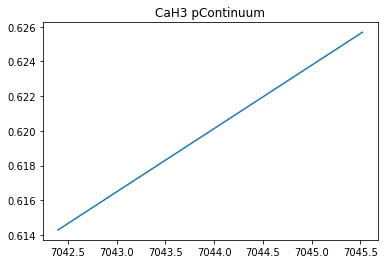

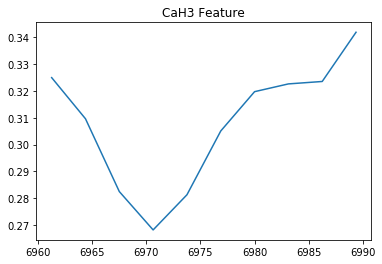

0.49669569577075895

In [16]:
waves = stand1.wave.value
fluxes = stand1.flux.value

CaH3_wave_cont = waves[ (waves > 7042) & (waves < 7046)]
CaH3_flux_cont = fluxes[ (waves > 7042) & (waves < 7046)]

CaH3_wave_feat = waves[ (waves > 6960) & (waves < 6990)]
CaH3_flux_feat = fluxes[ (waves > 6960) & (waves < 6990)]

plt.plot(CaH3_wave_cont, CaH3_flux_cont)
plt.title('CaH3 pContinuum')
plt.show()

plt.plot(CaH3_wave_feat, CaH3_flux_feat)
plt.title('CaH3 Feature')
plt.show()

pcontflux = np.mean(CaH3_flux_cont)
featflux = np.mean(CaH3_flux_feat)

CaH3_index = featflux / pcontflux

CaH3_index

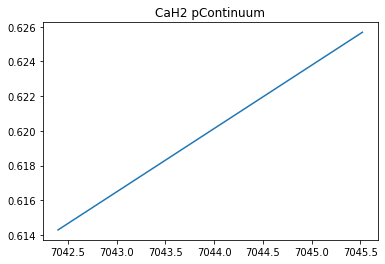

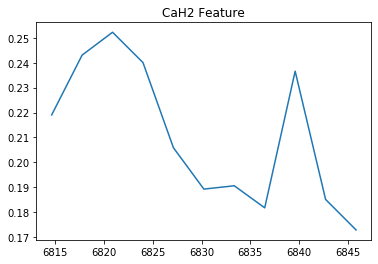

0.33968027563512115

In [17]:
waves = stand1.wave.value
fluxes = stand1.flux.value

CaH2_wave_cont = waves[ (waves > 7042) & (waves < 7046)]
CaH2_flux_cont = fluxes[ (waves > 7042) & (waves < 7046)]

CaH2_wave_feat = waves[ (waves > 6814) & (waves < 6846)]
CaH2_flux_feat = fluxes[ (waves > 6814) & (waves < 6846)]

plt.plot(CaH2_wave_cont, CaH2_flux_cont)
plt.title('CaH2 pContinuum')
plt.show()

plt.plot(CaH2_wave_feat, CaH2_flux_feat)
plt.title('CaH2 Feature')
plt.show()

pcontflux = np.mean(CaH2_flux_cont)
featflux = np.mean(CaH2_flux_feat)

CaH2_index = featflux / pcontflux

CaH2_index

In [18]:
CaH3 = CaH2_index + CaH3_index

spt = 1.4 * ( CaH3 )**2 - 10 * CaH3 + 12.4

solarTiO5 = -0.164 * CaH3 ** 3 + 0.670 * CaH3 ** 2 - 0.118 * CaH3 - 0.05
spt

5.01557495770438

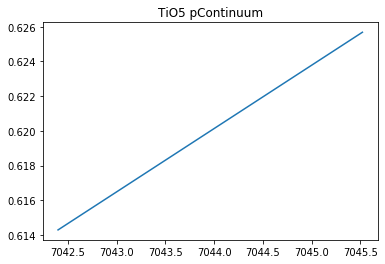

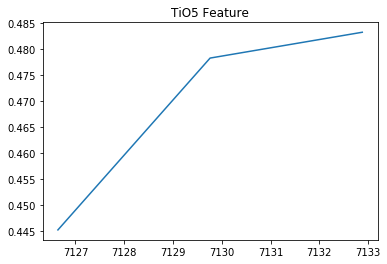

0.7564184812059905

In [19]:
waves = stand1.wave.value
fluxes = stand1.flux.value

TiO5_wave_cont = waves[ (waves > 7042) & (waves < 7046)]
TiO5_flux_cont = fluxes[ (waves > 7042) & (waves < 7046)]

TiO5_wave_feat = waves[ (waves > 7126) & (waves < 7135)]
TiO5_flux_feat = fluxes[ (waves > 7126) & (waves < 7135)]

plt.plot(TiO5_wave_cont, TiO5_flux_cont)
plt.title('TiO5 pContinuum')
plt.show()

plt.plot(TiO5_wave_feat, TiO5_flux_feat)
plt.title('TiO5 Feature')
plt.show()

pcontflux = np.mean(TiO5_flux_cont)
featflux = np.mean(TiO5_flux_feat)

TiO5_index = featflux / pcontflux

TiO5_index

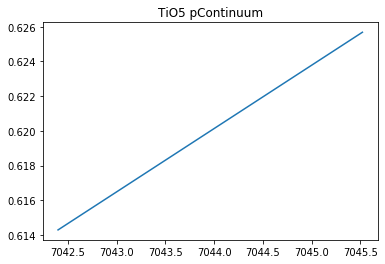

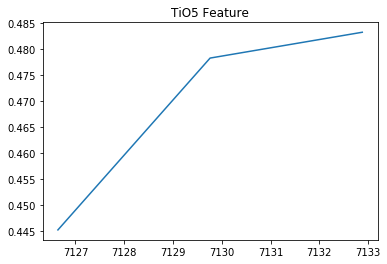

0.7564184812059905

In [20]:
waves = stand1.wave.value
fluxes = stand1.flux.value

TiO5_wave_cont = waves[ (waves >= 7042) & (waves <= 7046)]
TiO5_flux_cont = fluxes[ (waves >= 7042) & (waves <= 7046)]

TiO5_wave_feat = waves[ (waves >= 7126) & (waves <= 7135)]
TiO5_flux_feat = fluxes[ (waves >= 7126) & (waves <= 7135)]

plt.plot(TiO5_wave_cont, TiO5_flux_cont)
plt.title('TiO5 pContinuum')
plt.show()

plt.plot(TiO5_wave_feat, TiO5_flux_feat)
plt.title('TiO5 Feature')
plt.show()

pcontflux = np.mean(TiO5_flux_cont)
featflux = np.mean(TiO5_flux_feat)

TiO5_index = featflux / pcontflux

TiO5_index

In [21]:
zeta = (1 - TiO5_index)/(1 - solarTiO5)
zeta

0.31390926472610003

In [3]:
print(kastredux.compareSpectra_simple(sp1, stand1))
print(kastredux.compareSpectra_simple(sp1, stand2))


(139203.4858655595, 1.0811182242974623e-14)
(30574.64188978693, 1.88373850560153e-14)


In [3]:
def get_chi2(spec1, spec2):
    sp1 = copy.deepcopy(spec1)
    
    sp2 = copy.deepcopy(spec2)

    waves = sp1.wave.value
    f1 = sp1.flux.value
    u1 = sp1.unc.value
    #v1 = sp1.variance.value

    f2interp = kastredux.interp1d(sp2.wave.value, sp2.flux.value, bounds_error=False, fill_value=0.)
    u2interp = kastredux.interp1d(sp2.wave.value, sp2.unc.value, bounds_error=False, fill_value=0.)
    #v2interp = kastredux.interp1d(stand2.wave.value, stand2.variance.value, bounds_error=False, fill_value=0.)

    f2 = f2interp(waves)
    u2 = u2interp(waves)
    #v2 = v2interp(waves)

    #vartot = v1 + v2

    vartot = u1**2 #+ u2**2

    scalefactor = np.nansum( (f1 * f2)/ vartot )/np.nansum( f2**2 / vartot )

    chi2 = np.nansum( (f1 - scalefactor*f2)**2 /vartot )

    return chi2

In [24]:
CHI2 = []

for spec in STANDARDS:
    chi2 = get_chi2(sp1, spec)
    
    CHI2.append(chi2)
    
stdarr = np.array(STANDARDS)

print(np.amin(CHI2))
print(stdarr[ CHI2 == np.amin(CHI2) ][0].name)

17841.46705228801
M60_SDSS-bochanski2007


In [6]:
for spec in STANDARDS:
    chi2 = get_chi2(sp1, spec)
    
    print('chi2: {}; name: {}'.format(chi2, spec.name))

chi2: 419278.8513129336; name: T50_2MASS0559-1404-burgasser2003
chi2: 139203.4858655595; name: M20_SDSS-bochanski2007
chi2: 144968.92693349224; name: sdM10_LSPMJ0938+2200-lepine2007
chi2: 166975.0182826653; name: usdM55_LSPMJ1202+1645-lepine2007
chi2: 374093.9252107437; name: T00_SDSS0837-0000-burgasser2003
chi2: 218008.7967401127; name: L50_SDSS-schmidt2017
chi2: 107792.12152231444; name: L30_2MASS1146+2230-kirkpatrick1999
chi2: 58751.17393782745; name: sdM50_LSPMJ1448+6148-lepine2007
chi2: 118715.08125289954; name: sdM20_LSPMJ1014+4354-lepine2007
chi2: 183391.07166633318; name: L50_2MASS1228-1547-kirkpatrick1999
chi2: 47719.95946108667; name: M40_SDSS-bochanski2007
chi2: 185338.34779091267; name: usdM20_LSPMJ0440+1538-lepine2007
chi2: 30574.64188978693; name: M70_SDSS-bochanski2007
chi2: 17841.46705228801; name: M60_SDSS-bochanski2007
chi2: 25441.217024842976; name: M50_SDSS-bochanski2007
chi2: 238551.08447864756; name: esdK70_LSPMJ0448+2206-lepine2007
chi2: 254442.85622780537; name:

In [8]:
for spec in STANDARDS:
    
    chi2 = mod_get_chi2(sp1, spec)
    
    print('chi2: {}; name: {}'.format(chi2, spec.name))

/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


chi2: 0.0; name: T50_2MASS0559-1404-burgasser2003
chi2: 1224.8452906758748; name: M20_SDSS-bochanski2007
chi2: 0.0; name: sdM10_LSPMJ0938+2200-lepine2007
chi2: 0.0; name: usdM55_LSPMJ1202+1645-lepine2007
chi2: 0.0; name: T00_SDSS0837-0000-burgasser2003
chi2: 54848.26396909516; name: L50_SDSS-schmidt2017
chi2: 0.0; name: L30_2MASS1146+2230-kirkpatrick1999
chi2: 0.0; name: sdM50_LSPMJ1448+6148-lepine2007
chi2: 0.0; name: sdM20_LSPMJ1014+4354-lepine2007
chi2: 0.0; name: L50_2MASS1228-1547-kirkpatrick1999
chi2: 1224.8452906758748; name: M40_SDSS-bochanski2007
chi2: 0.0; name: usdM20_LSPMJ0440+1538-lepine2007
chi2: 1224.8452906758748; name: M70_SDSS-bochanski2007
chi2: 1224.8452906758748; name: M60_SDSS-bochanski2007
chi2: 1224.8452906758748; name: M50_SDSS-bochanski2007
chi2: 0.0; name: esdK70_LSPMJ0448+2206-lepine2007
chi2: 1224.8452906758748; name: M00_SDSS-bochanski2007
chi2: 0.0; name: usdM75_LSPMJ0822+1700-lepine2007
chi2: 0.0; name: T80_2MASS0415-0935-burgasser2003
chi2: 0.0; name: T

In [9]:
for spec in STANDARDS:
    stat, scalefactor = kastredux.compareSpectra(sp1, spec, novar2=False)
    
    print('chi2: {}; name: {}'.format(stat, spec.name))
    

/home/ryan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


chi2: 419278.8513129336; name: T50_2MASS0559-1404-burgasser2003
chi2: 1224.8452906758748; name: M20_SDSS-bochanski2007
chi2: 144968.92693349224; name: sdM10_LSPMJ0938+2200-lepine2007
chi2: 166975.0182826653; name: usdM55_LSPMJ1202+1645-lepine2007
chi2: 374093.9252107437; name: T00_SDSS0837-0000-burgasser2003
chi2: 54848.26396909516; name: L50_SDSS-schmidt2017
chi2: 107792.12152231444; name: L30_2MASS1146+2230-kirkpatrick1999
chi2: 58751.17393782745; name: sdM50_LSPMJ1448+6148-lepine2007
chi2: 118715.08125289954; name: sdM20_LSPMJ1014+4354-lepine2007
chi2: 183391.07166633318; name: L50_2MASS1228-1547-kirkpatrick1999
chi2: 1224.8452906758748; name: M40_SDSS-bochanski2007
chi2: 185338.34779091267; name: usdM20_LSPMJ0440+1538-lepine2007
chi2: 1224.8452906758748; name: M70_SDSS-bochanski2007
chi2: 1224.8452906758748; name: M60_SDSS-bochanski2007
chi2: 1224.8452906758748; name: M50_SDSS-bochanski2007
chi2: 238551.08447864756; name: esdK70_LSPMJ0448+2206-lepine2007
chi2: 1224.8452906758748; n

In [11]:
STATS = []
SCALEFACTORS = []

for spec in STANDARDS:
    stat, scalefactor = kastredux.compareSpectra_simple(sp1, spec, novar2=False)
    
    STATS.append(stat)
    
    SCALEFACTORS.append(scalefactor)

In [12]:
np.amin(STATS)

17841.46705228801

In [56]:
STATS = []
SCALEFACTORS = []

for spec in STANDARDS:
    stat, scalefactor = kastredux.compareSpectra(sp1, spec)
    
    STATS.append(stat)
    
    SCALEFACTORS.append(scalefactor)
    


/home/ryan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [60]:
statarr = np.array(STATS)

print(len(statarr[statarr < 1500]))

0


/home/ryan/code/kastredux/core.py:1095: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,(ax1,ax2) = plt.subplots(2,1,sharex='col',figsize=kwargs.get('figsize',[8,8]))


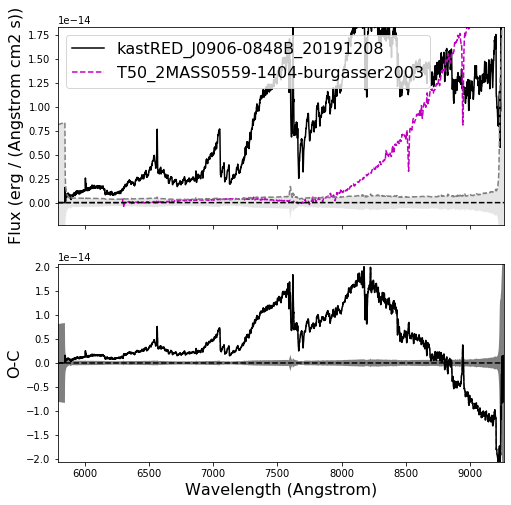

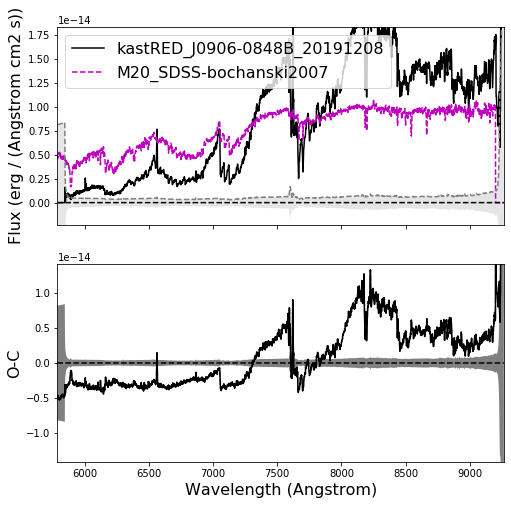

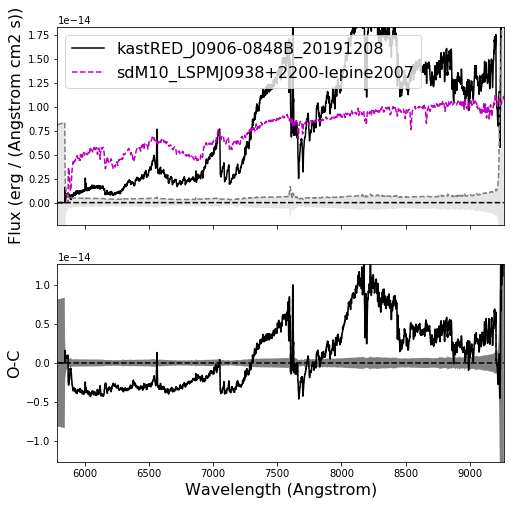

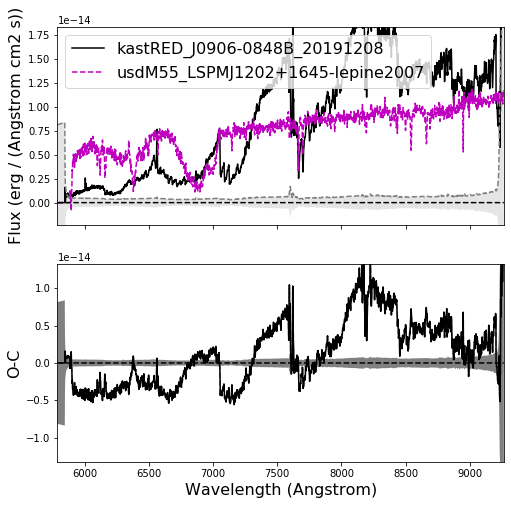

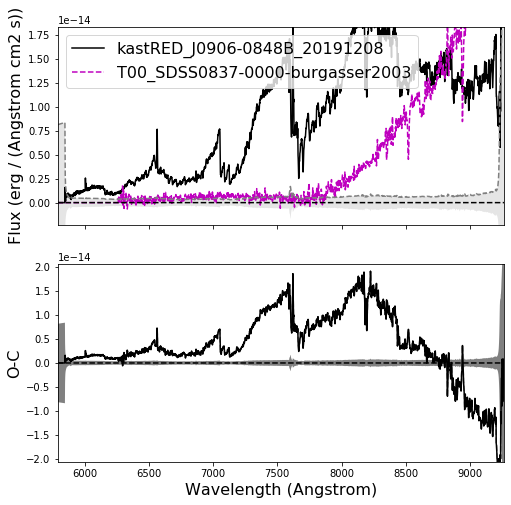

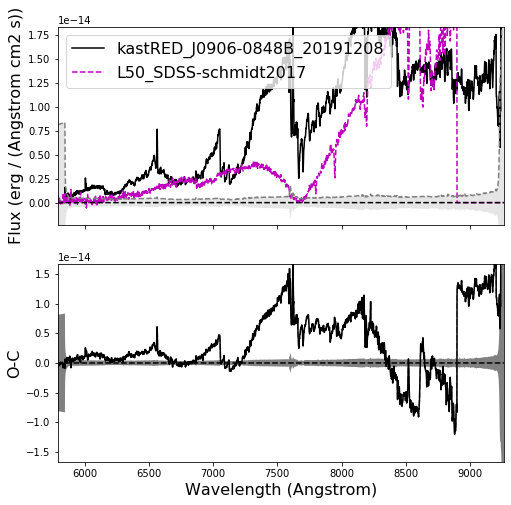

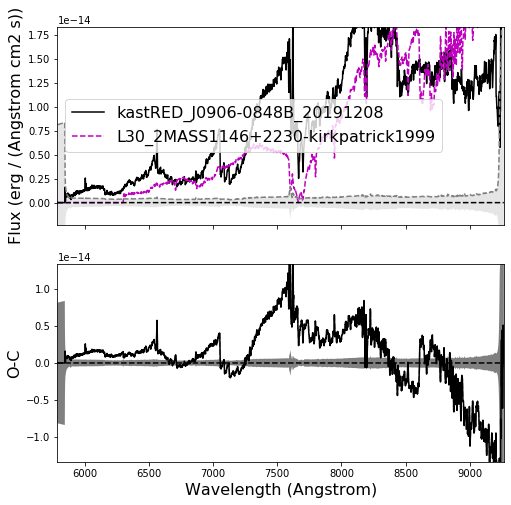

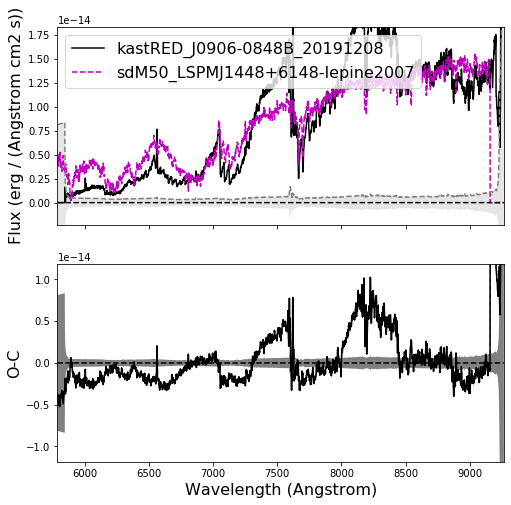

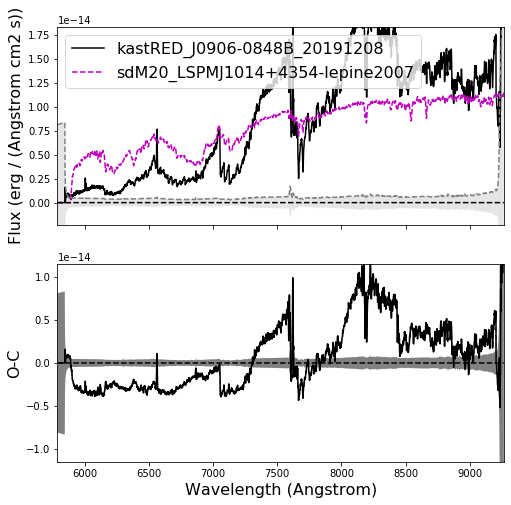

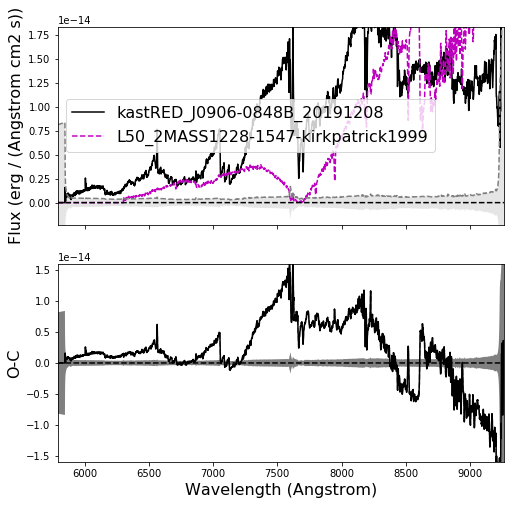

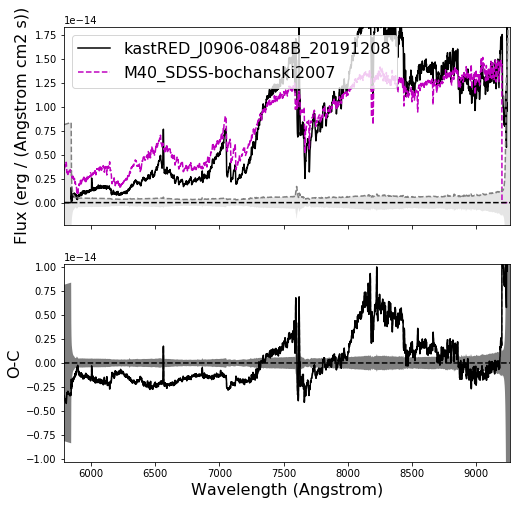

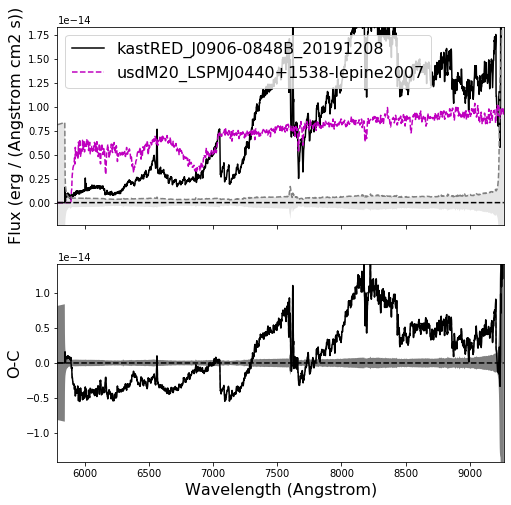

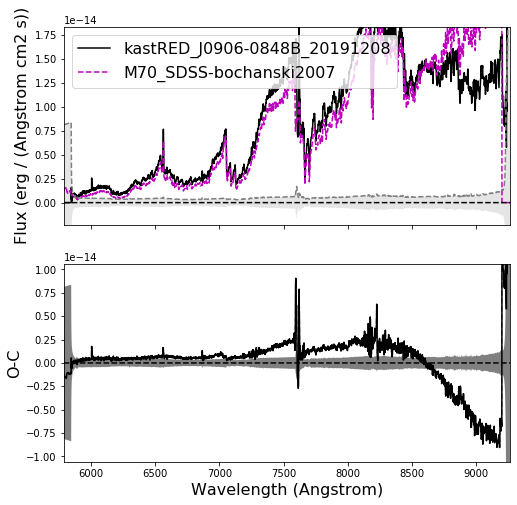

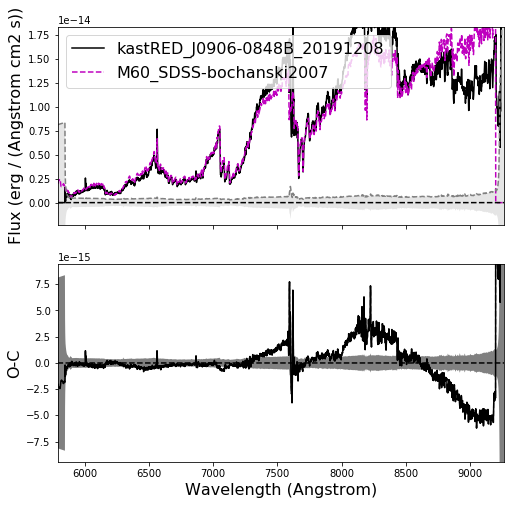

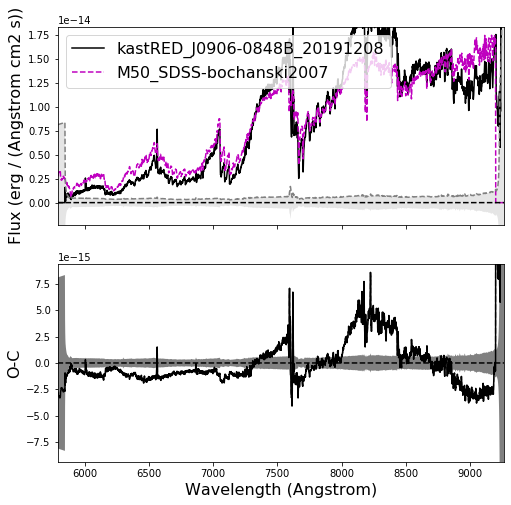

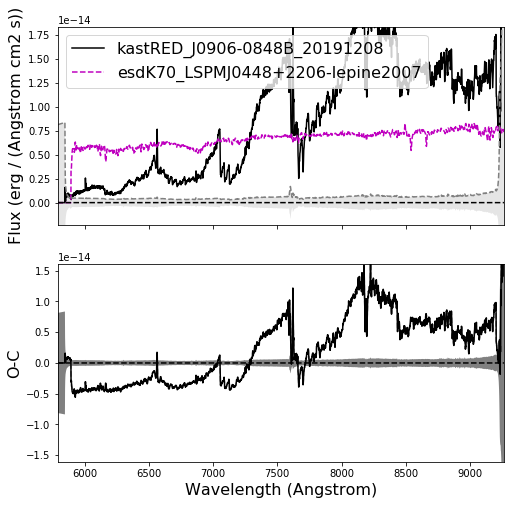

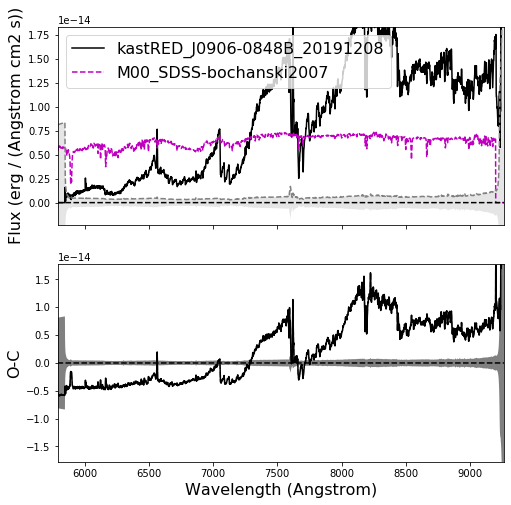

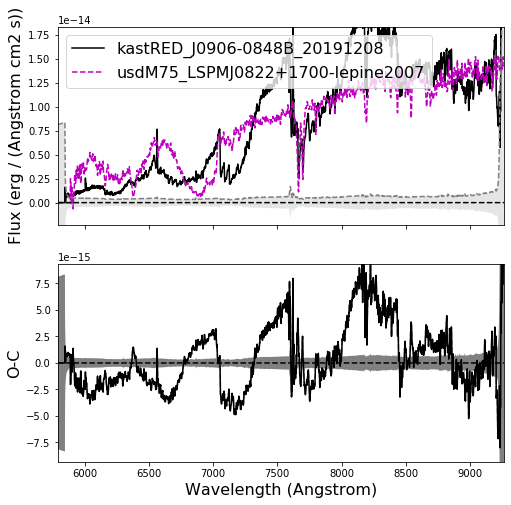

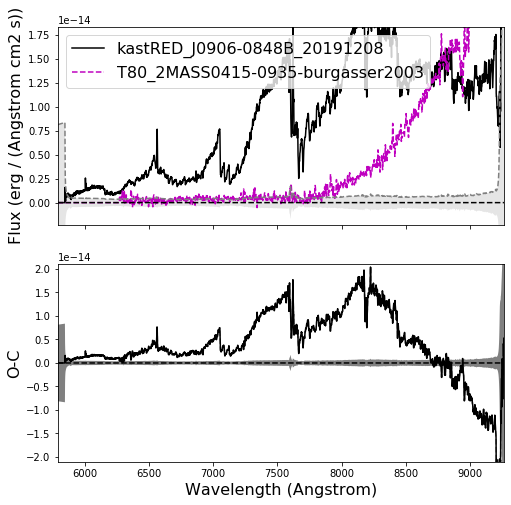

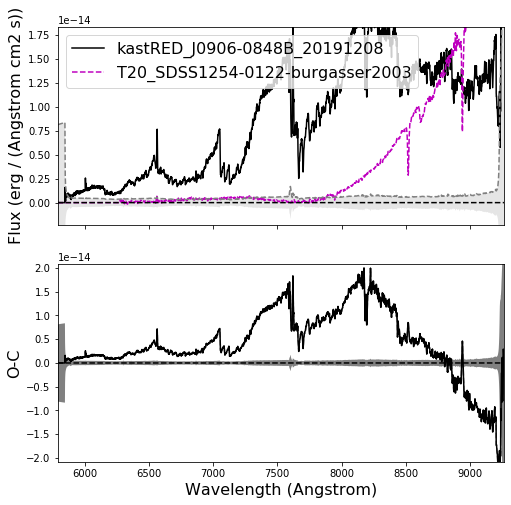

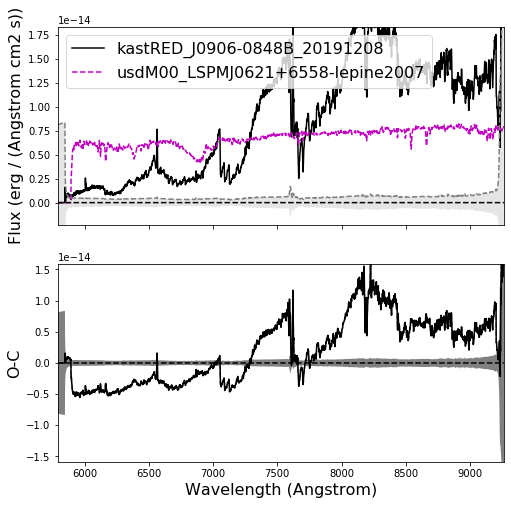

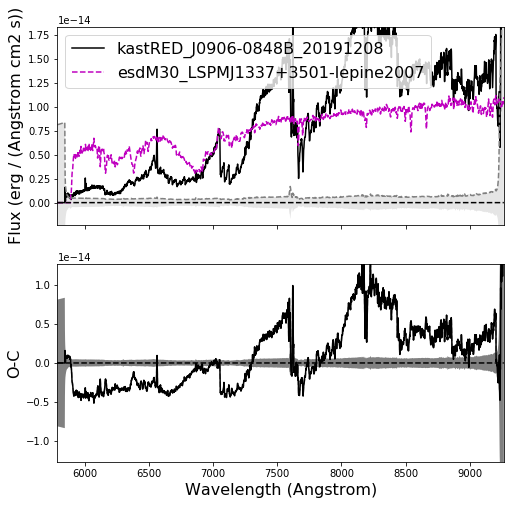

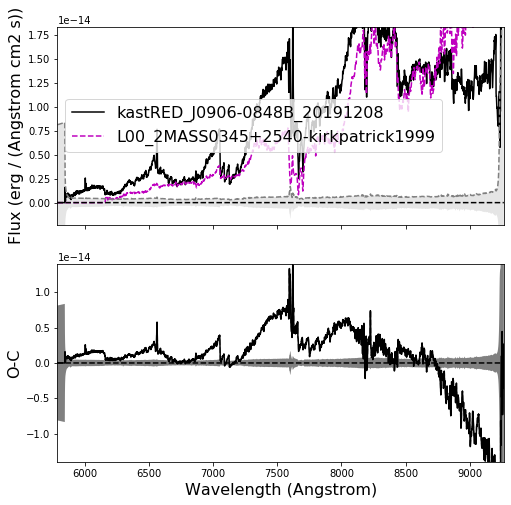

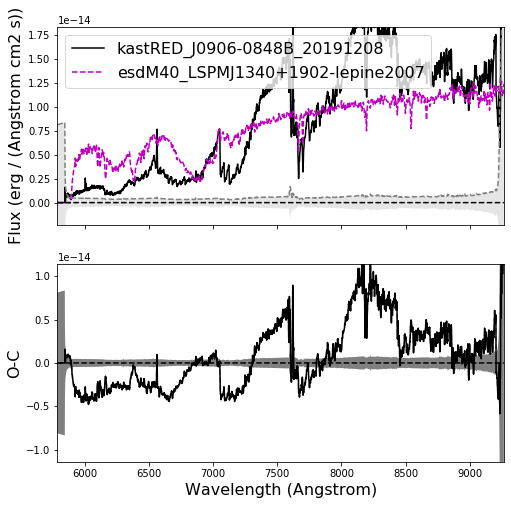

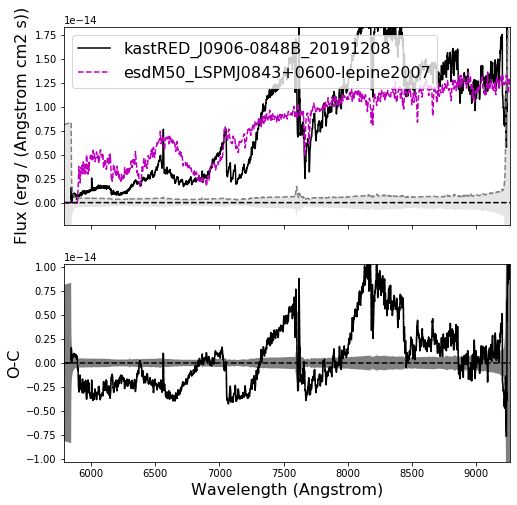

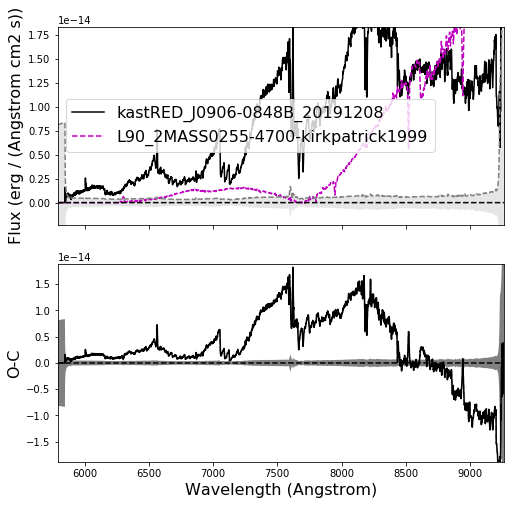

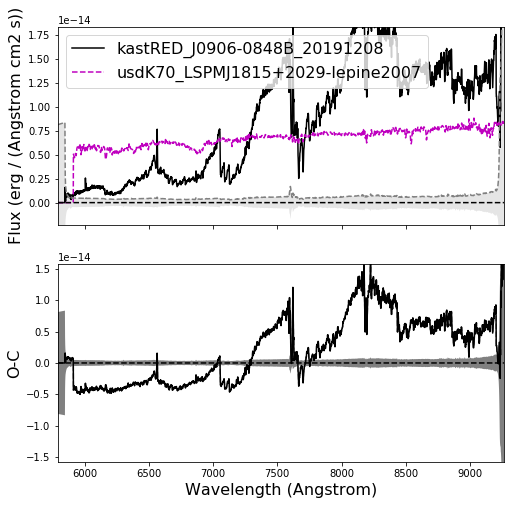

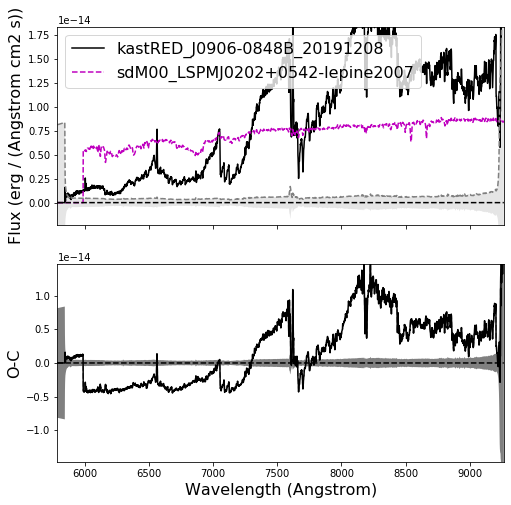

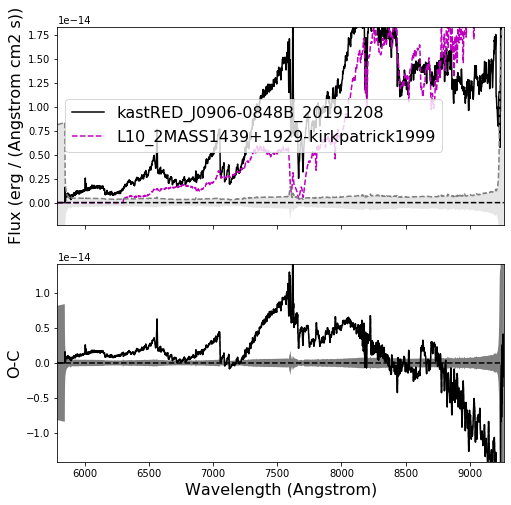

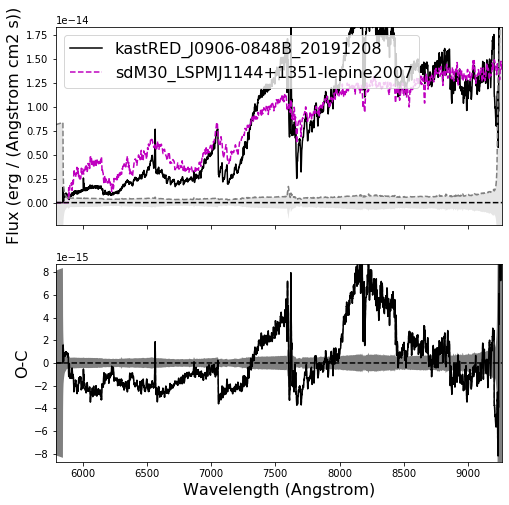

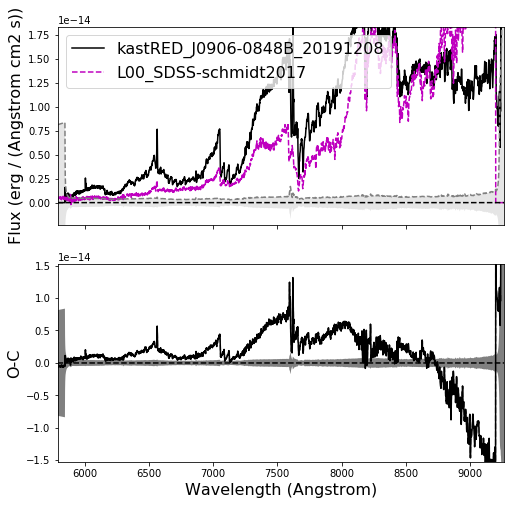

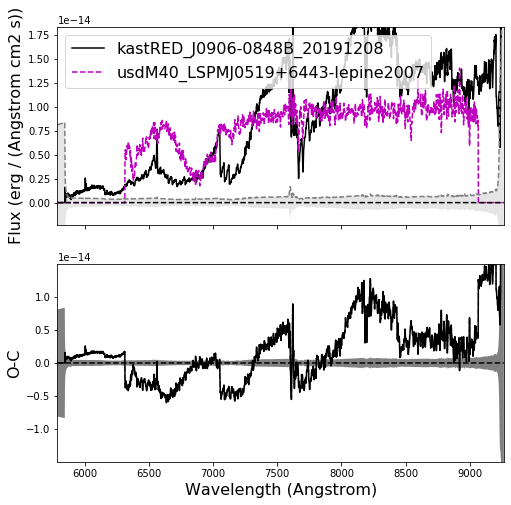

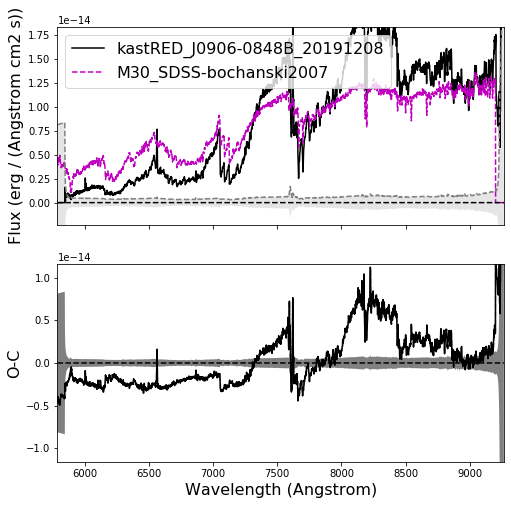

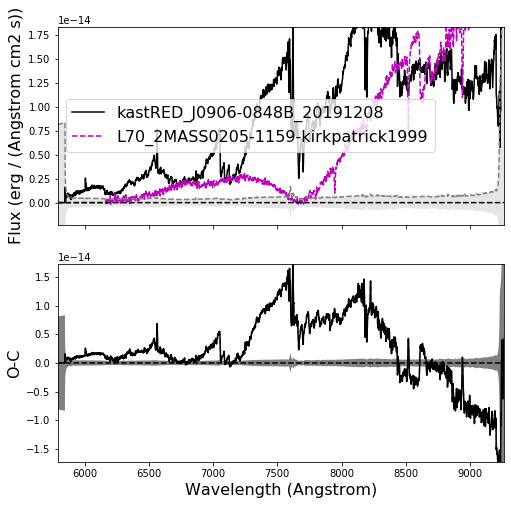

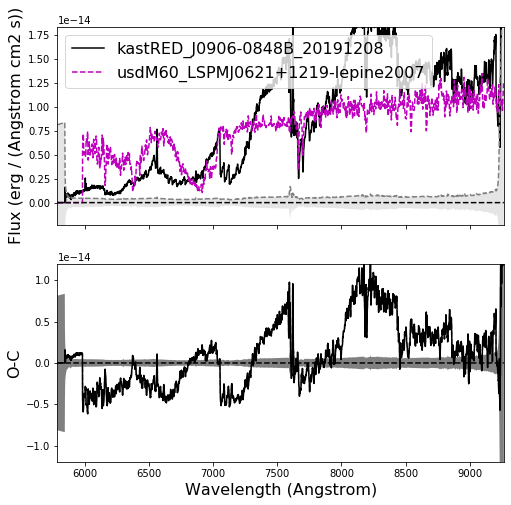

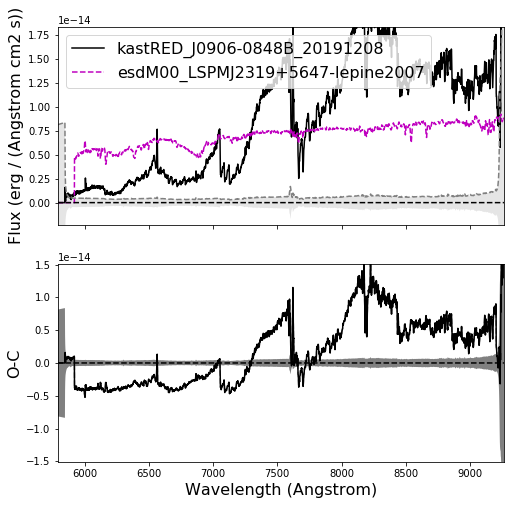

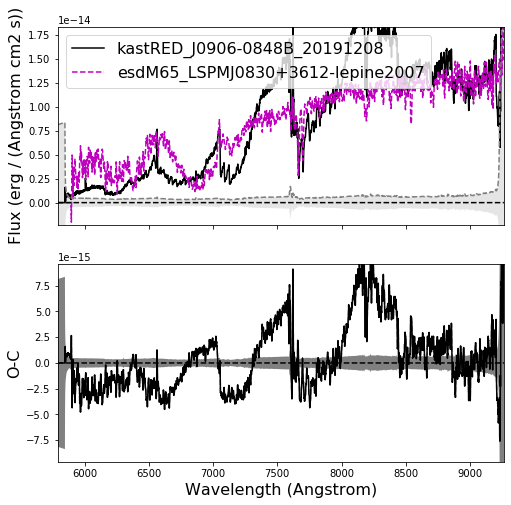

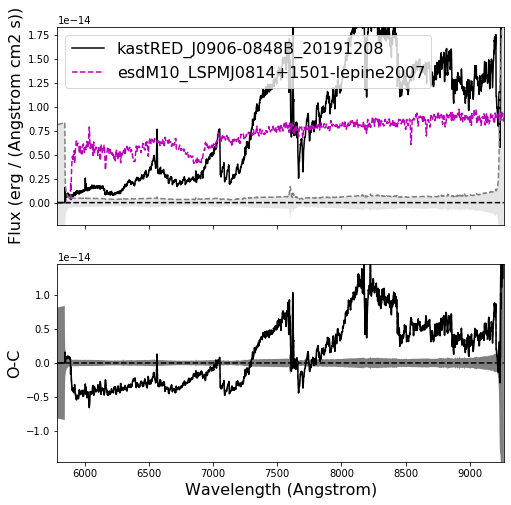

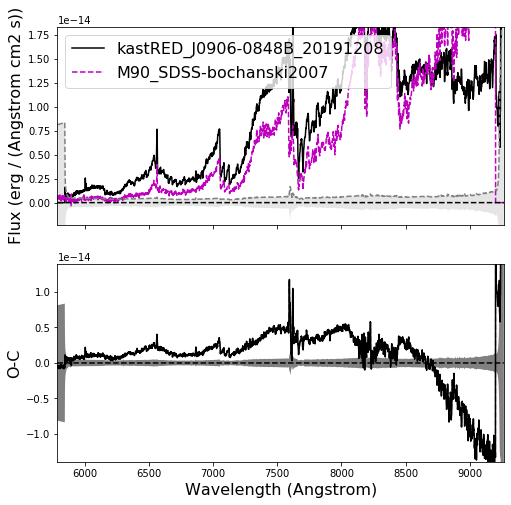

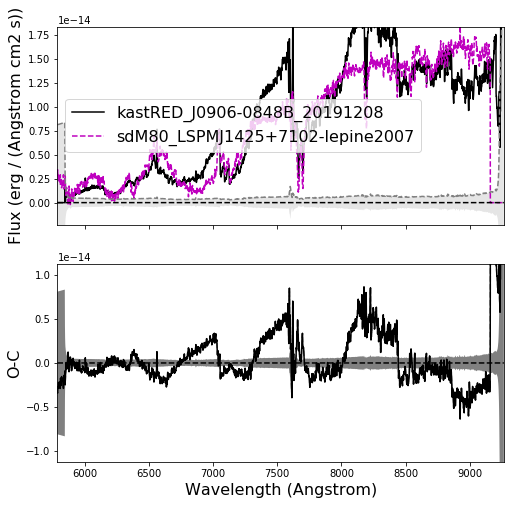

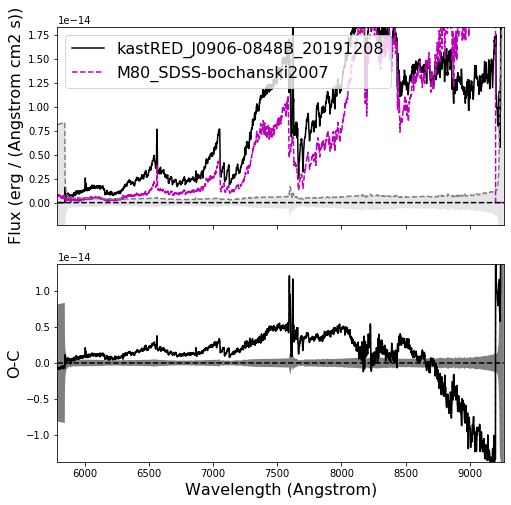

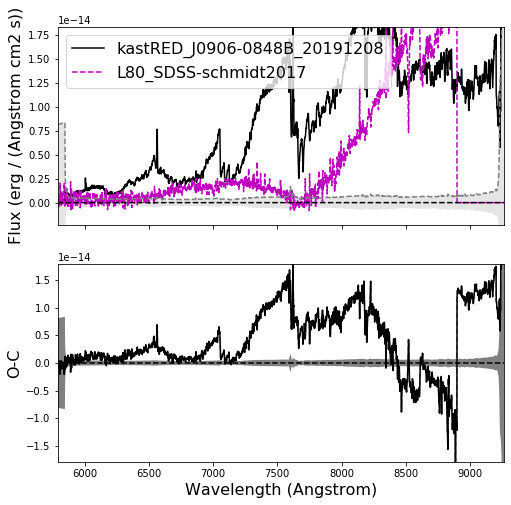

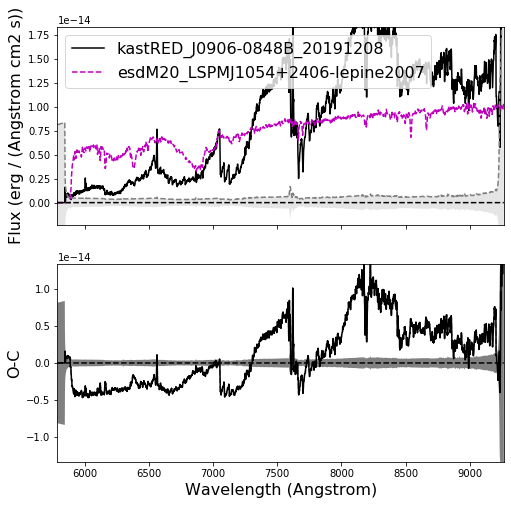

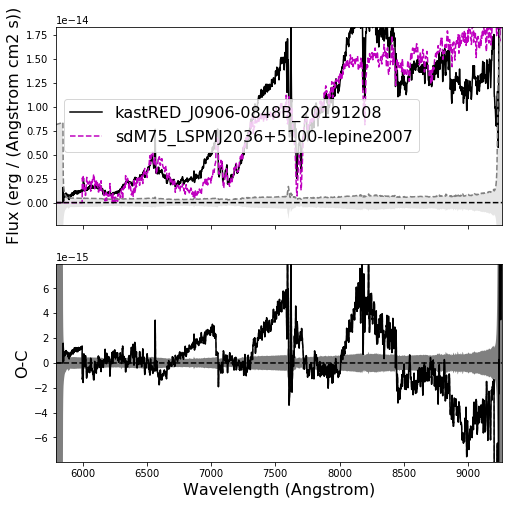

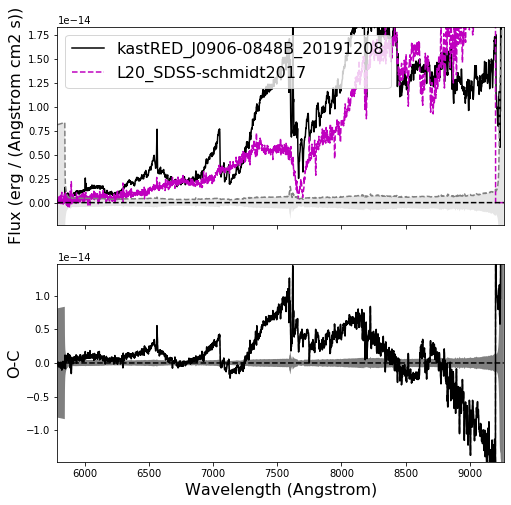

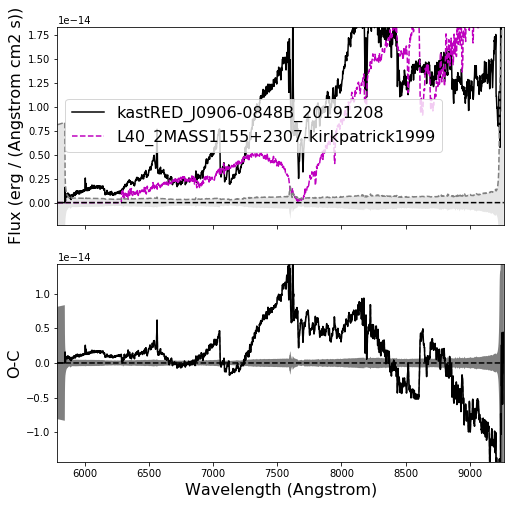

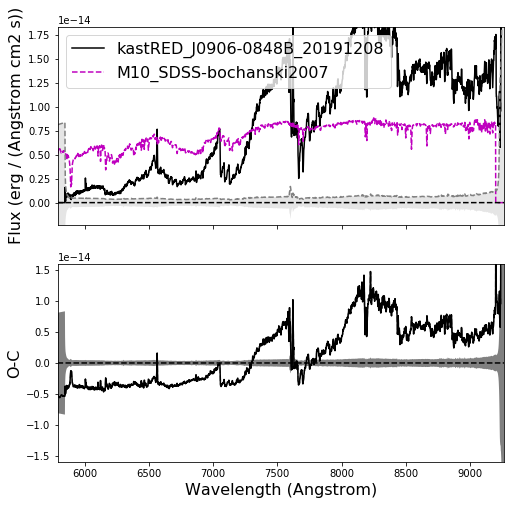

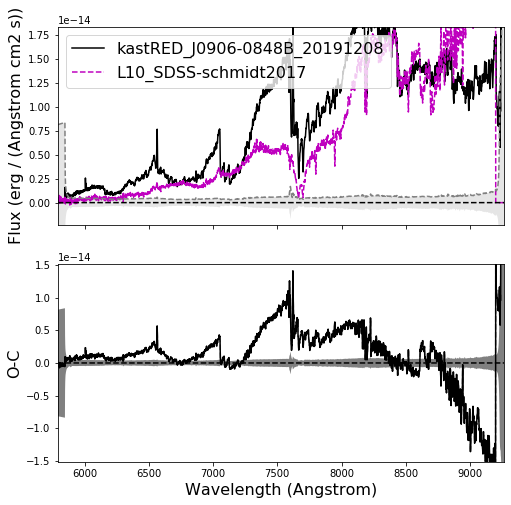

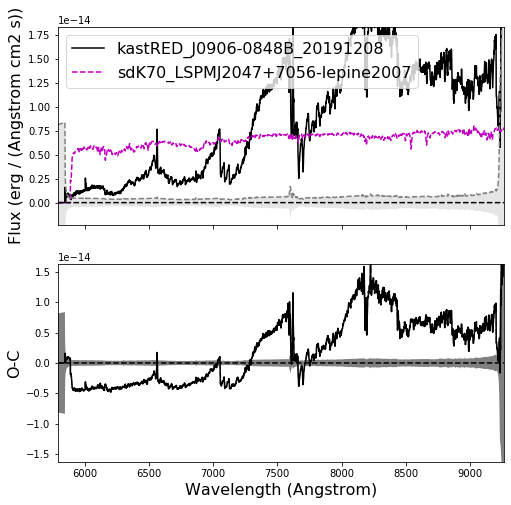

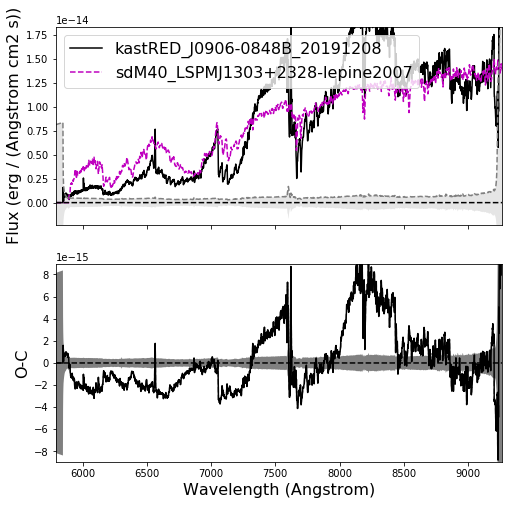

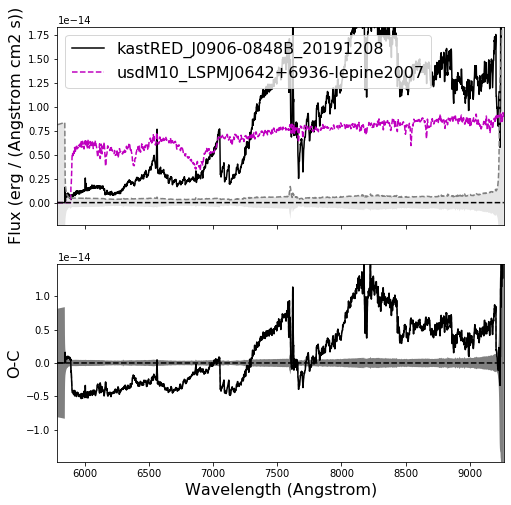

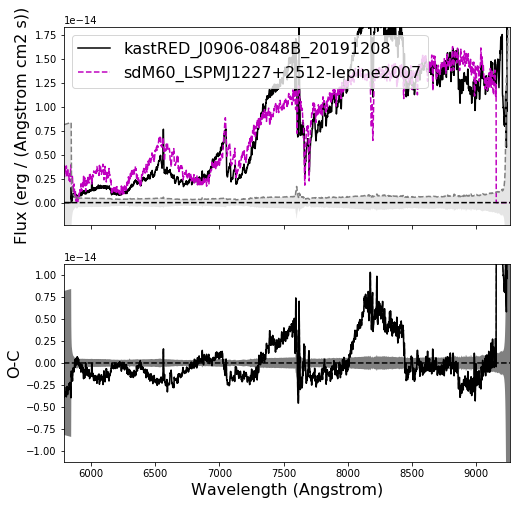

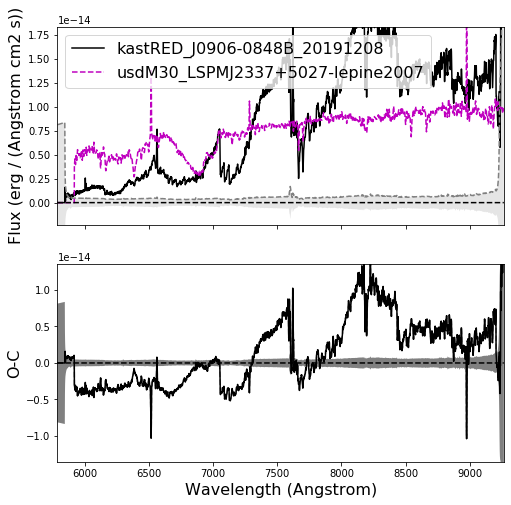

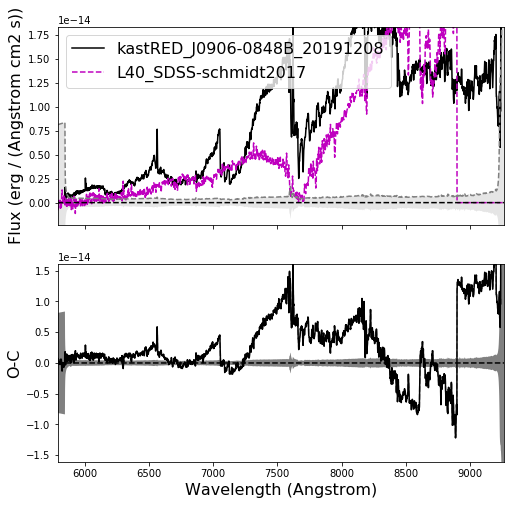

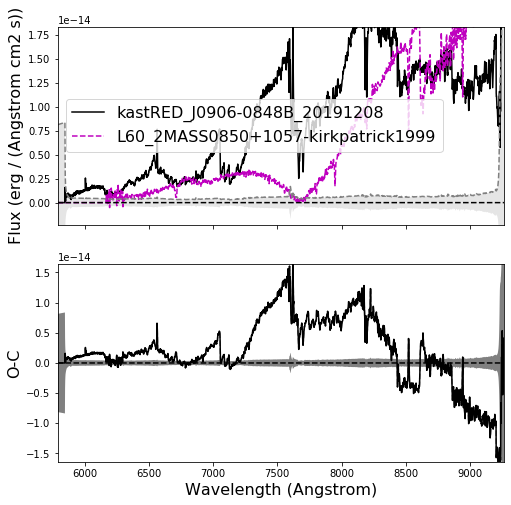

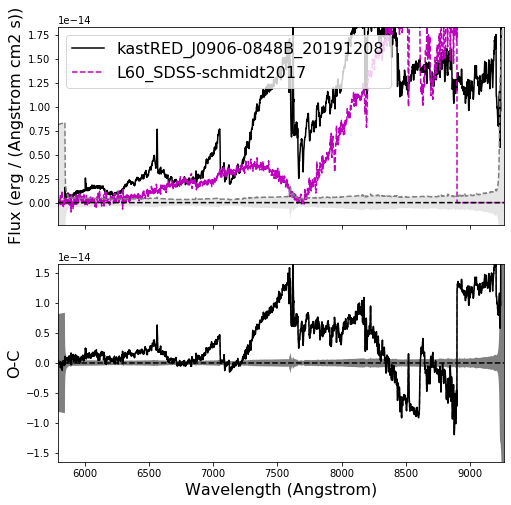

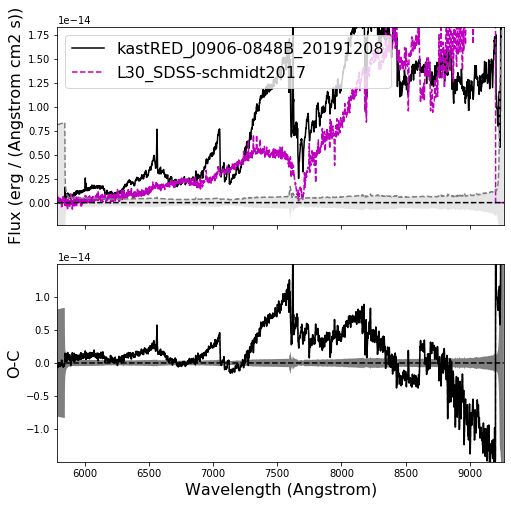

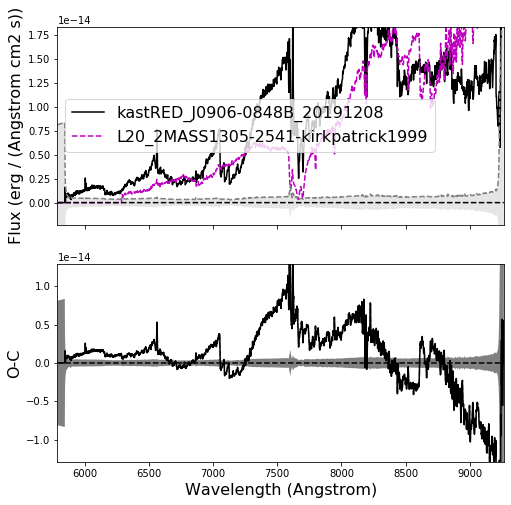

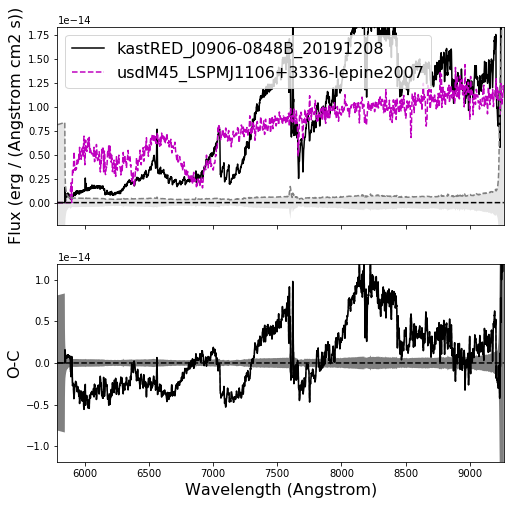

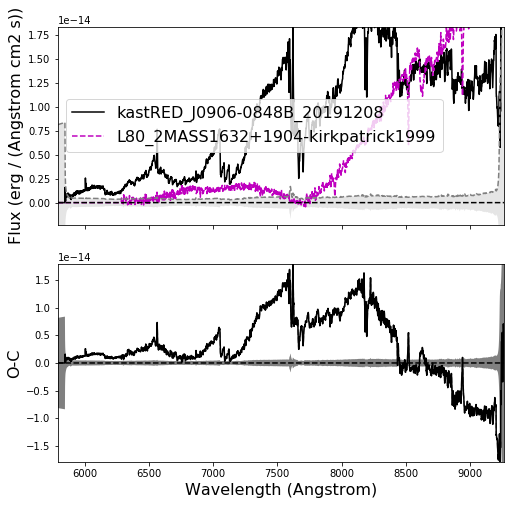

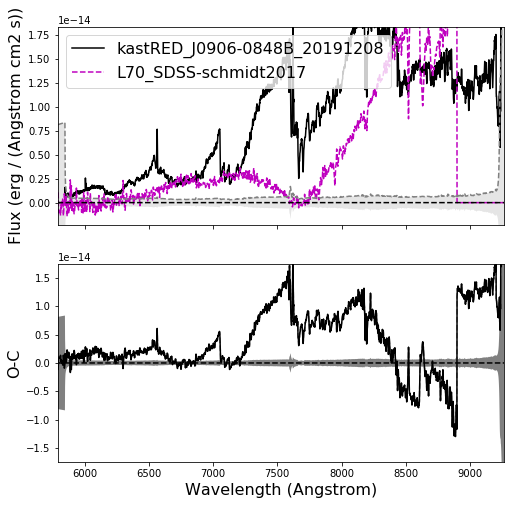

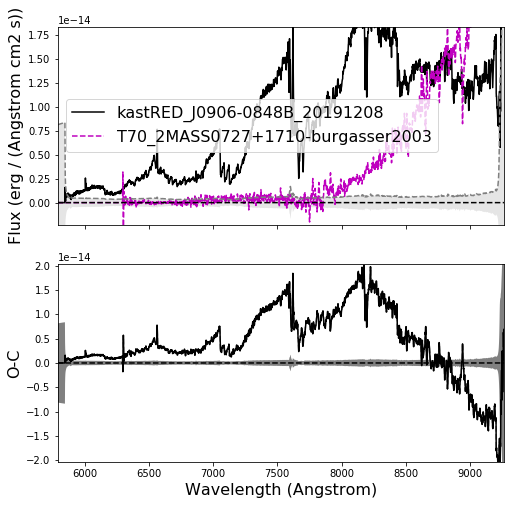

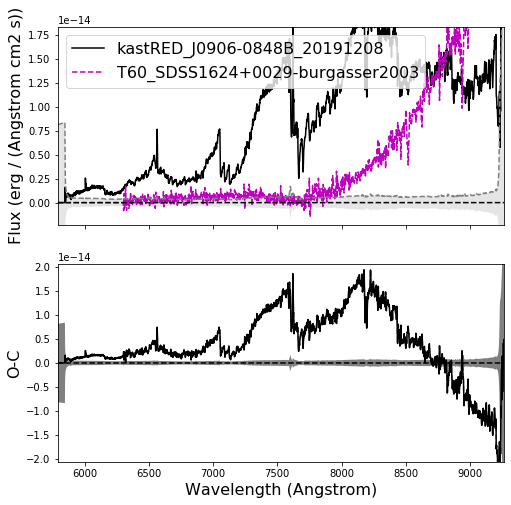

In [17]:
for stand in STANDARDS:
    stat, scale = kastredux.compareSpectra_simple(sp1, stand, plot=True)

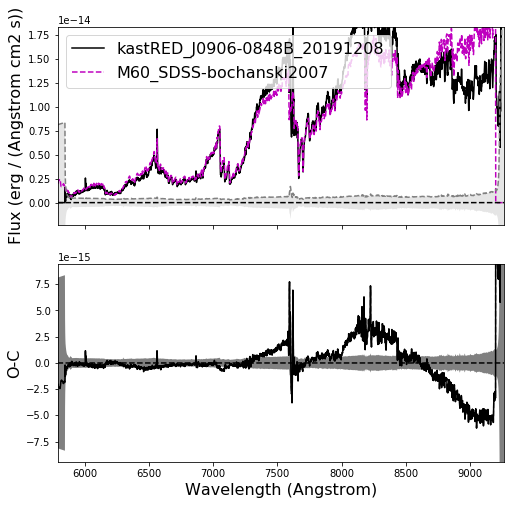

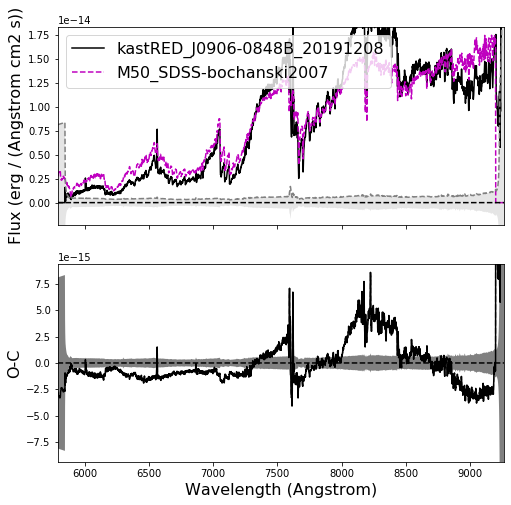

In [18]:
for i in range(len(STATS)):
    if STATS[i] < 30000:
        stat, scale = kastredux.compareSpectra_simple(sp1, STANDARDS[i], plot=True)
        

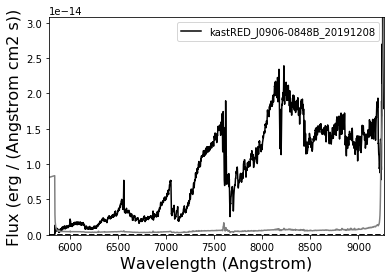

In [5]:
sp1.plot()

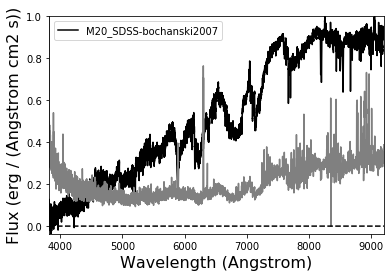

In [9]:
stand1.plot()

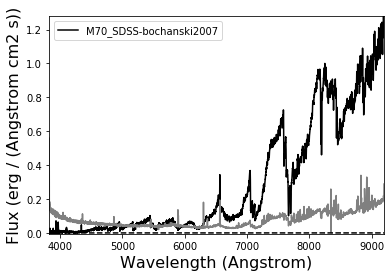

In [10]:
stand2.plot()

0.22978852199690908


(1224.8452906758748, 1.0365752692075261e-14)

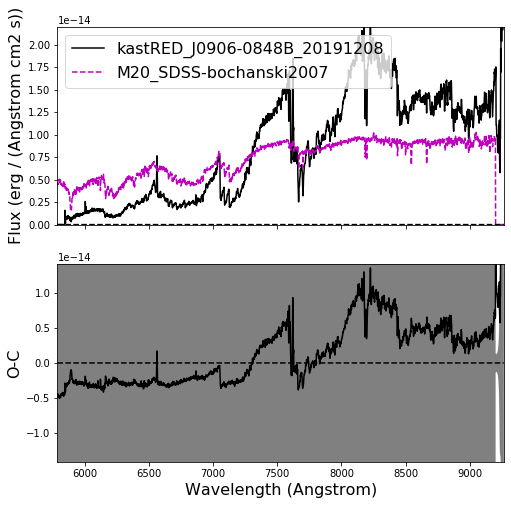

In [10]:
kastredux.compareSpectra(sp1, stand1, plot=True)

0.07665725877536597


(1224.8452906758748, 1.9970201178816747e-14)

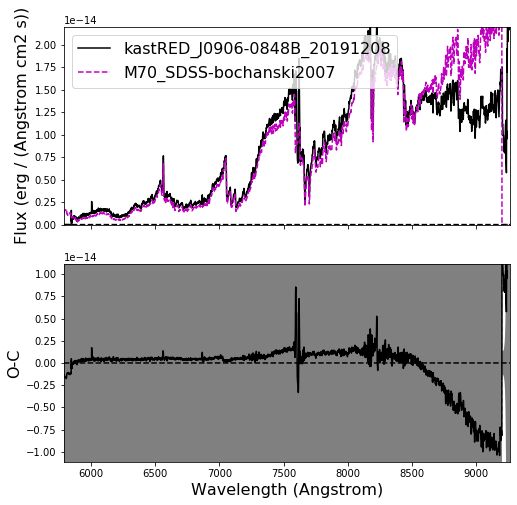

In [11]:
kastredux.compareSpectra(sp1, stand2 ,plot=True)

In [7]:
print('chi2: {}; name: {}'.format(test_compareSpectra(sp1, stand1)[0], stand1.name))
print('chi2: {}; name: {}'.format(test_compareSpectra(sp1, stand2)[0], stand2.name))
print('chi2: {}; name: {}'.format(test_compareSpectra(sp1, stand3)[0], stand3.name))

print(test_compareSpectra(sp1, stand1)[0] == test_compareSpectra(sp1, stand2)[0])

chi2: 1224.8452906758748; name: M20_SDSS-bochanski2007
chi2: 1224.8452906758748; name: M70_SDSS-bochanski2007
chi2: 1224.8452906758748; name: M00_SDSS-bochanski2007
True


In [8]:
flx1 = sp1.flux.value

wave = sp1.wave.value

var1 = sp1.unc.value
var2 = stand1.unc.value

f2interp = kastredux.interp1d(stand1.wave.value, stand1.flux.value,bounds_error=False,fill_value=0.)
u2interp = kastredux.interp1d(stand1.wave.value,stand1.unc.value,bounds_error=False,fill_value=0.)

flx2 = f2interp(wave)
var2 = u2interp(wave)

vartot = var1**2 + var2**2

scale_fac = np.nansum(flx1*flx2/vartot) / np.nansum((flx2**2)/vartot)

In [9]:
scale_fac

1.0365752692075261e-14

In [10]:
chi2_1 = numpy.nansum((flx1-scale_fac * flx2)**2/vartot)
chi2_1

1224.8452906758748

In [11]:
flx1 = sp1.flux.value

wave = sp1.wave.value

var1 = sp1.unc.value
var3 = stand2.unc.value

f3interp = kastredux.interp1d(stand2.wave.value, stand2.flux.value,bounds_error=False,fill_value=0.)
u3interp = kastredux.interp1d(stand2.wave.value,stand2.unc.value,bounds_error=False,fill_value=0.)

flx3 = f3interp(wave)
var3 = u2interp(wave)

vartot = var1**2 + var3**2

scale_fac = np.nansum(flx1*flx3/vartot) / np.nansum((flx3**2)/vartot)

In [12]:
scale_fac

1.8584930262128095e-14

In [13]:
chi2_2 = numpy.nansum((flx1-scale_fac * flx3)**2/vartot)
chi2_2

1224.8452906758748

In [14]:
flx1 = sp1.flux.value

wave = sp1.wave.value

var1 = sp1.unc.value
var4 = stand3.unc.value

f4interp = kastredux.interp1d(stand3.wave.value, stand3.flux.value,bounds_error=False,fill_value=0.)
u4interp = kastredux.interp1d(stand3.wave.value,stand3.unc.value,bounds_error=False,fill_value=0.)

flx4 = f4interp(wave)
var4 = u4interp(wave)

vartot = var1**2 + var4**2

scale_fac = np.nansum(flx1*flx4/vartot) / np.nansum((flx4**2)/vartot)

In [15]:
scale_fac

1.1443071981611523e-14

In [16]:
chi2_3 = numpy.nansum((flx1-scale_fac * flx4)**2/vartot)
chi2_3

1224.8452906758748

In [94]:
vartot = numpy.nanmax([sp1.variance.value,f4interp(sp1.wave.value)],axis=0)

scale_factor = numpy.nansum(sp1.flux.value*f4interp(sp1.wave.value)/vartot)/numpy.nansum(f4interp(sp1.wave.value)*f4interp(sp1.wave.value)/vartot)

scale_factor

9.675560224619643e-15

In [95]:

vartot = numpy.nanmax([sp1.variance.value,f4interp(sp1.wave.value)*(scale_factor**2)],axis=0)

stat_4 = numpy.nansum((sp1.flux.value-f4interp(sp1.wave.value)*scale_factor)**2/vartot)
stat_4

2191.5843499045973

In [98]:
for stand in STANDARDS:
    if np.all(np.isnan(stand.unc.value)):
        print(stand.name)

T50_2MASS0559-1404-burgasser2003
sdM10_LSPMJ0938+2200-lepine2007
usdM55_LSPMJ1202+1645-lepine2007
T00_SDSS0837-0000-burgasser2003
L30_2MASS1146+2230-kirkpatrick1999
sdM50_LSPMJ1448+6148-lepine2007
sdM20_LSPMJ1014+4354-lepine2007
L50_2MASS1228-1547-kirkpatrick1999
usdM20_LSPMJ0440+1538-lepine2007
esdK70_LSPMJ0448+2206-lepine2007
usdM75_LSPMJ0822+1700-lepine2007
T80_2MASS0415-0935-burgasser2003
T20_SDSS1254-0122-burgasser2003
usdM00_LSPMJ0621+6558-lepine2007
esdM30_LSPMJ1337+3501-lepine2007
L00_2MASS0345+2540-kirkpatrick1999
esdM40_LSPMJ1340+1902-lepine2007
esdM50_LSPMJ0843+0600-lepine2007
L90_2MASS0255-4700-kirkpatrick1999
usdK70_LSPMJ1815+2029-lepine2007
sdM00_LSPMJ0202+0542-lepine2007
L10_2MASS1439+1929-kirkpatrick1999
sdM30_LSPMJ1144+1351-lepine2007
usdM40_LSPMJ0519+6443-lepine2007
L70_2MASS0205-1159-kirkpatrick1999
usdM60_LSPMJ0621+1219-lepine2007
esdM00_LSPMJ2319+5647-lepine2007
esdM65_LSPMJ0830+3612-lepine2007
esdM10_LSPMJ0814+1501-lepine2007
sdM80_LSPMJ1425+7102-lepine2007
esdM20

In [81]:
def generateMask(wv,mask=[],mask_range=[-99.,-99.],mask_telluric=False,mask_standard=False,**kwargs):
    '''
    :Purpose: Generates a mask array based on wavelength vector and optional inputs on what to mask.

    :Output: A mask array, where 0 = OK and 1 = ignore

    :Example:
    '''

# parameter check
    wave = copy.deepcopy(wv)
    if isinstance(wv,kastredux.Spectrum): wave = wv.wave
    if not kastredux.isUnit(wv): wave = wave*DEFAULT_WAVE_UNIT
    if not isinstance(wave.value,list) and not isinstance(wave.value,numpy.ndarray):
        raise ValueError('\nInput parameter should be an array of wavelengths; you passed {}'.format(wv))

# generate initial mask 
    if len(mask) == 0:
        mask = numpy.zeros(len(wave))
    mask = numpy.array(mask)
    if len(mask) != len(wave):
        raise ValueError('\nInitial mask of length {} is not the same as wave array of len {}'.format(len(mask),len(wave)))


    
# a standard masking
    mask_ranges = kwargs.get('mask_ranges',[mask_range])
    '''
    Standard and Telluric masking will have to be different
    for kast; assumes microns, NIR ranges for tellurics,
    and NIR ranges for A star standards
    if mask_standard == True:
        mask_telluric = True
        mask_ranges.append([0.,0.8]*DEFAULT_WAVE_UNIT)        # standard short cut

# mask telluric bands
    if mask_telluric == True:
#        mask_ranges.append([0.,0.65]*DEFAULT_WAVE_UNIT)        # meant to clear out short wavelengths
        mask_ranges.append([1.35,1.42]*DEFAULT_WAVE_UNIT)
        mask_ranges.append([1.8,1.92]*DEFAULT_WAVE_UNIT)
        mask_ranges.append([2.45,99.]*DEFAULT_WAVE_UNIT)        # meant to clear out long wavelengths
        
        
    '''

# make sure quantities are all correct
    mask_ranges_apply = []
    for i,m in enumerate(mask_ranges):
        if not kastredux.isUnit(m): m = m*wave.unit
        m.to(wave.unit)
        mask_ranges_apply.append(m)

# apply to mask
    for m in mask_ranges_apply:
        mask[numpy.where(numpy.logical_and(wave.value >= numpy.nanmin(m.value),wave.value <= numpy.nanmax(m.value)))]= 1

    return mask

In [82]:
def test_compareSpectra(s1, s2, statistic='chisqr',scale=True, novar2=True, plot=False, verbose=False, **kwargs):
    '''
    
    NEED TO MODIFY HEADER COMMENT FOR KAST
    
    
    :Purpose: 

        Compare two spectra against each other using a pre-selected statistic. 
        Returns the value of the desired statistic as well as the optimal scale factor. 

    :Required Parameters: 

        :param sp1: First spectrum class object, which sets the wavelength scale
        :param sp2: Second spectrum class object, interpolated onto the wavelength scale of sp1

    :Optional Parameters: 

        :param: statistic = 'chisqr': string defining which statistic to use in comparison; available options are (also stat):

            - *'chisqr'* or *'chi'*: compare by computing chi squared value (requires spectra with noise values)
            - *'stddev'*: compare by computing standard deviation
            - *'stddev_norm'*: compare by computing normalized standard deviation
            - *'absdev'*: compare by computing absolute deviation

        :param: scale = True: If True, finds the best scale factor to minimize the statistic
        :param: fit_ranges = [range of first spectrum]: 2-element array or nested array of 2-element arrays specifying the wavelength ranges to be used for the fit, assumed to be measured in microns; this is effectively the opposite of mask_ranges (also fit_range, fitrange, fitrng, comprange, comprng)
        :param: mask = numpy.zeros(): Array specifiying which wavelengths to mask; must be an array with length equal to the wavelength scale of ``sp1`` with only 0 (OK) or 1 (mask).
        :param: mask_ranges = None: Multi-vector array setting wavelength boundaries for masking data, assumed to be in microns
        :param: mask_telluric = False: Set to True to mask pre-defined telluric absorption regions
        :param: mask_standard = False: Like ``mask_telluric``, with a slightly tighter cut of 0.80-2.35 micron
        :param: weights = numpy.ones(): Array specifying the weights for individual wavelengths; must be an array with length equal to the wavelength scale of ``sp1``; need not be normalized
        :param: novar2 = True: Set to True to compute statistic without considering variance of ``sp2``
        :param: plot = False: Set to True to plot ``sp1`` with scaled ``sp2`` and difference spectrum overlaid
        :param: verbose = False: Set to True to report things as you're going along

    :Output: 
        statistic and optimal scale factor for the comparison

    :Example:
        >>> import splat
        >>> import numpy
        >>> sp1 = splat.getSpectrum(shortname = '2346-3153')[0]
            Retrieving 1 file
        >>> sp2 = splat.getSpectrum(shortname = '1421+1827')[0]
            Retrieving 1 file
        >>> sp1.normalize()
        >>> sp2.normalize()    
        >>> splat.compareSpectra(sp1, sp2, statistic='chisqr')
            (<Quantity 19927.74527822856>, 0.94360732593223595)
        >>> splat.compareSpectra(sp1, sp2, statistic='stddev')
            (<Quantity 3.0237604611215705 erg2 / (cm4 micron2 s2)>, 0.98180983971456637)
        >>> splat.compareSpectra(sp1, sp2, statistic='absdev')
            (<Quantity 32.99816249949072 erg / (cm2 micron s)>, 0.98155779612333172)
        >>> splat.compareSpectra(sp1, sp2, statistic='chisqr', novar2=False)
            (<Quantity 17071.690727945213>, 0.94029474635786015)
    '''

    sp1 = copy.deepcopy(s1)
    sp2 = copy.deepcopy(s2)
    
# make sure spectra are on the same wavelength and flux unit scales
    if sp1.wave.unit != sp2.wave.unit: sp2.toWaveUnit(sp1.wave.unit)
    if sp1.flux.unit != sp2.flux.unit: sp2.toFluxUnit(sp1.flux.unit)

    fit_ranges = kwargs.get('fit_ranges',[[numpy.nanmin(sp1.wave),numpy.nanmax(sp1.wave)]])
    fit_ranges = kwargs.get('fit_range',fit_ranges)
    fit_ranges = kwargs.get('fitrange',fit_ranges)
    fit_ranges = kwargs.get('fitrng',fit_ranges)
    fit_ranges = kwargs.get('comprange',fit_ranges)
    fit_ranges = kwargs.get('comprng',fit_ranges)
#    mask_ranges = kwargs.get('mask_ranges',[])
#    mask_standard = kwargs.get('mask_standard',False)
#    mask_telluric = kwargs.get('mask_telluric',mask_standard)
    var_flag = novar2
    if numpy.isnan(numpy.max(sp2.variance.value)) == True: var_flag = True
    if numpy.isnan(numpy.max(sp1.variance.value)) == True: var_flag = False
    statistic = kwargs.get('stat',statistic)
    minreturn = 1.e-60
    scale_factor = 1.

# create interpolation function for second spectrum
    f = kastredux.interp1d(sp2.wave.value,sp2.flux.value,bounds_error=False,fill_value=0.)
    if var_flag:
        v = kastredux.interp1d(sp2.wave.value,[numpy.nan for s in sp2.wave],bounds_error=False,fill_value=numpy.nan)
    else:
        v = kastredux.interp1d(sp2.wave.value,sp2.variance.value,bounds_error=False,fill_value=numpy.nan)
# total variance - funny form to cover for nans
    vtot = numpy.nanmax([sp1.variance.value,v(sp1.wave.value)],axis=0)

# manage fit ranges and generate fit mask
    if len(fit_ranges) == 0: fit_ranges = [[numpy.nanmin(sp1.wave),numpy.nanmax(sp1.wave)]]
    if len(fit_ranges) == 2 and not isinstance(fit_ranges[0],list): fit_ranges = [fit_ranges]
    
    '''
    for i,m in enumerate(fit_ranges):
        if not kastredux.isUnit(m):
            fit_ranges[i] = (m*u.micron).to(sp1.wave.unit)
    '''
    fit_mask = kwargs.get('fit_mask',1.-generateMask(sp1.wave,mask_ranges=fit_ranges))
    
# generate masking array and combine with fit mask
#    reject_mask = numpy.array(kwargs.get('mask',generateMask(sp1.wave,**kwargs)))
    reject_mask = numpy.array(kwargs.get('mask',numpy.zeros(len(sp1.wave))))
# mask flux < 0
    reject_mask[numpy.where(numpy.logical_or(sp1.flux < 0,f(sp1.wave) < 0))] = 1
    mask = numpy.clip(fit_mask+reject_mask,0,1)

# set the weights
    weights = kwargs.get('weights',numpy.ones(len(sp1.wave)))
    weights = weights*(1.-mask)

# comparison statistics
# switch to standard deviation if no uncertainty
    if numpy.isnan(numpy.nanmax(vtot)):
        statistic = 'stddev'
        if verbose==True:
            print('No uncertainties provided; using the {} statistic by default'.format(statistic))
    else:
        if verbose==True:
            print('Comparing spectra using the {} statistic'.format(statistic))

# chi^2
    if (statistic == 'chisqr' or statistic == 'chisq' or statistic == 'chi'):
# compute scale factor
        if scale == True:
            scale_factor = numpy.nansum(weights*sp1.flux.value*f(sp1.wave.value)/vtot)/ \
                numpy.nansum(weights*f(sp1.wave.value)*f(sp1.wave.value)/vtot)
# correct variance
        vtot = numpy.nanmax([sp1.variance.value,v(sp1.wave.value)*(scale_factor**2)],axis=0)
        stat = numpy.nansum(weights*(sp1.flux.value-f(sp1.wave.value)*scale_factor)**2/vtot)
        unit = sp1.flux.unit/sp1.flux.unit

# normalized standard deviation
    elif (statistic == 'stddev_norm' or statistic == 'stdev_norm'):
# compute scale factor
        if scale == True:
            scale_factor = numpy.nansum(weights*sp1.flux.value)/ \
                numpy.nansum(weights*f(sp1.wave.value))
# correct variance
        vtot = numpy.nanmax([sp1.variance.value,v(sp1.wave.value)*(scale_factor**2)],axis=0)
        stat = numpy.nansum(weights*(sp1.flux.value-f(sp1.wave.value)*scale_factor)**2)/ \
            numpy.median(sp1.flux.value)**2
        unit = sp1.flux.unit/sp1.flux.unit

# standard deviation
    elif (statistic == 'stddev' or statistic == 'stdev'):
# compute scale factor
        if scale == True:
            scale_factor = numpy.nansum(weights*sp1.flux.value*f(sp1.wave.value))/ \
                numpy.nansum(weights*f(sp1.wave.value)*f(sp1.wave.value))
# correct variance
        vtot = numpy.nanmax([sp1.variance.value,v(sp1.wave.value)*(scale_factor**2)],axis=0)
        stat = numpy.nansum(weights*(sp1.flux.value-f(sp1.wave.value)*scale_factor)**2)
        unit = sp1.flux.unit**2

# absolute deviation
    elif (statistic == 'absdev'):
# compute scale factor
        if scale == True:
            scale_factor = numpy.nansum(weights*sp1.flux.value)/ \
                numpy.nansum(weights*f(sp1.wave.value))
# correct variance
        vtot = numpy.nanmax([sp1.variance.value,v(sp1.wave.value)*(scale_factor**2)],axis=0)
        stat = numpy.nansum(weights*abs(sp1.flux.value-f(sp1.wave.value)*scale_factor))
        unit = sp1.flux.unit

# error
    else:
        print('Error: statistic {} for compareSpectra not available'.format(statistic))
        return numpy.nan, numpy.nan

    
#plotting is from splat, need to retrofit this to work with kastredux
    '''

# plot spectrum compared to best spectrum
    if plot == True:
        spcomp = sp2.copy()
        spcomp.scale(scale_factor)
        kwargs['colors'] = kwargs.get('colors',['k','r','b'])
        kwargs['title'] = kwargs.get('title',sp1.name+' vs '+sp2.name)
        from .plot import plotSpectrum
        plotSpectrum(sp1,spcomp,sp1-spcomp,labels=[sp1.name,sp2.name,'{} = {}'.format(statistic,stat)],**kwargs)
    '''

    return numpy.nanmax([stat,minreturn])*unit, scale_factor

In [ ]:
    


def measure_lepine_indices(spec):
    
    waves = spec.wave.value
    fluxes = spec.flux.value
    fluxinterp = kastredux.interp1d(waves, fluxes, bounds_error=False, fill_value=0.)
    
    minwavelength = 5000
    maxwavelength = 10000
    
    no_divisions = (maxwavelength - minwavelength) * 1000
    
    w = numpy.linspace(minwavelength, maxwavelength, no_divisions)
    
    f = fluxinterp(w)
    
    #CaH3_wave_cont = w[ (w > 7042) & (w < 7046)]
    CaH3_flux_cont = f[ (w > 7042) & (w < 7046)]
    
    #CaH3_wave_feat = w[ (w > 6960) & (w < 6990)]
    CaH3_flux_feat = f[ (w > 6960) & (w < 6990)]
    
    pcontflux = numpy.mean(CaH3_flux_cont)
    featflux = numpy.mean(CaH3_flux_feat)

    CaH3_index = numpy.divide(featflux, pcontflux)
    
    #CaH2_wave_cont = w[ (w > 7042) & (w < 7046)]
    CaH2_flux_cont = f[ (w > 7042) & (w < 7046)]
    
    #CaH2_wave_feat = w[ (w > 6814) & (w < 6846)]
    CaH2_flux_feat = f[ (w > 6814) & (w < 6846)]
    
    pcontflux = numpy.mean(CaH2_flux_cont)
    featflux = numpy.mean(CaH2_flux_feat)

    CaH2_index = numpy.divide(featflux, pcontflux)
    
    #TiO5_wave_cont = w[ (w > 7042) & (w < 7046)]
    TiO5_flux_cont = f[ (w > 7042) & (w < 7046)]

    #TiO5_wave_feat = w[ (w > 7126) & (w < 7135)]
    TiO5_flux_feat = f[ (w > 7126) & (w < 7135)]
    
    pcontflux = numpy.mean(TiO5_flux_cont)
    featflux = numpy.mean(TiO5_flux_feat)

    TiO5_index = numpy.divide(featflux , pcontflux)
    
    return [CaH3_index, CaH2_index, TiO5_index]


def measure_lepine_spt(spec):
    
    indices = measure_lepine_indices(spec)
    
    CaH3 = indices[0]
    CaH2 = indices[1]
    
    CaH = CaH2 + CaH3
    
    spt = 1.4 * CaH**2 - 10. * CaH + 12.4
    
    return spt

def measure_lepine_zeta(spec):
    
    indices = measure_lepine_indices(spec)
    
    CaH3 = indices[0]
    
    CaH2 = indices[1]
    
    TiO5 = indices[2]
    
    CaH = CaH2 + CaH3
    
    solar_TiO5 = -0.164 * CaH ** 3 + 0.670 * CaH ** 2 - 0.118 * CaH - 0.050
    
    zeta = np.divide((1 - TiO5), (1 - solar_TiO5))
    
    return zeta


In [48]:
def generate_mc(waverange, fluxrange, uncrange):
    
    waves = waverange
    fluxes = fluxrange
    uncs = uncrange

    fluxdist = numpy.random.normal(fluxes, uncs)
    
    return fluxdist


def measure_index(spec, waveranges):
    
    no_trials = 1000
    
    no_samples = 1000
    
    index_samples = []
    
    waves = spec.wave.value
    fluxes = spec.flux.value
    uncs = spec.unc.value
    
    for i in range(no_trials):
        
        index_fluxes = []
        
        fluxes_sample = generate_mc(waves, fluxes, uncs)
        
        fluxinterp = interp1d(waves, fluxes_sample, bounds_error=False, fill_value=0.)
    
        for waverange in waveranges:
            
            minwavelength = waverange[0]
            maxwavelength = waverange[1]

            no_divisions = (maxwavelength - minwavelength) * no_samples

            w = numpy.linspace(minwavelength, maxwavelength, no_divisions)

            f = fluxinterp(w)

            feature_flux = f[ (w > minwavelength) & (w < maxwavelength)]

            index_flux = np.mean(feature_flux)

            index_fluxes.append(index_flux)

        index_samples.append( index_fluxes[1] / index_fluxes[0] )
        
    index = np.mean(index_samples)
    index_unc = np.std(index_samples)
    
    return index, index_unc

In [90]:
x = 5
dx = 0.02
y = 7
dy = 0.1

f = x * y
df2 = y**2 * dx**2 + x**2 + dy**2


xsamps = np.random.normal(x, dx,10000)

ysamps = np.random.normal(y, dy,10000)

    
fsamps = xsamps * ysamps

fapprox = np.mean(fsamps)
ferr = np.std(fsamps)

print(f, np.sqrt(df2))

print(fapprox, ferr)

35 5.002959124358304
34.99933577773804 0.5239654019169419


3.877306291270667

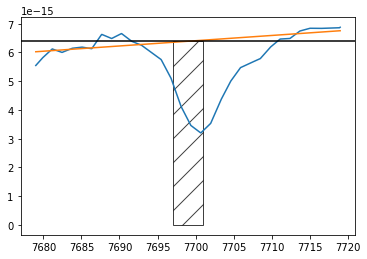

In [134]:
feature_center = 7699

feature_radius = 10
cont_radius = 20

waves = sp1.wave.value
fluxes = sp1.flux.value

feature_waves = np.linspace( feature_center - feature_radius, feature_center + feature_radius, 1000)

finterp = interp1d(waves, fluxes, bounds_error=False, fill_value=0.)

feature_flux = finterp(feature_waves)

cont_waves = np.linspace( feature_center - cont_radius, feature_center + cont_radius, 1000)

cont_f = finterp(cont_waves)

cont_fluxes = cont_f[ (cont_waves <= feature_center - feature_radius) | (cont_waves >= feature_center + feature_radius)]

cont_wv = cont_waves[ (cont_waves <= feature_center - feature_radius) | (cont_waves >= feature_center + feature_radius) ]

cont_fit = np.poly1d( np.polyfit(cont_wv, cont_fluxes, 1) )


center_wv = np.median(cont_waves)

continuum_level = cont_fit(center_wv)

width = trapz( (np.ones(len(feature_flux)) - feature_flux / continuum_level), feature_waves)

from matplotlib import patches

lower_left = feature_center - width/2

fig, ax = plt.subplots(1)
rect = patches.Rectangle( (lower_left, 0), width, continuum_level, fill=False,hatch='/', alpha=0.75)
ax.add_patch(rect)
ax.plot(cont_waves, cont_f)
ax.plot(cont_waves, cont_fit(cont_waves))
ax.axhline(continuum_level, color='k')

width